# Plots report
Miscellaneous plots and experimentsfor the report.

## Setup

In [3]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

setup_notebook()

In [155]:
DATA_PATH = '../data/'
quotation = 'JNJ'
FILE_SUFFIX = '.txt'
price_column = 'Close'

In [156]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}{FILE_SUFFIX}")
data_wrapper.compute_features(predict_n=1, thresh_diff=0.005)
data_wrapper.head()

Date       Open       High        Low      Close    Volume  \
0  2007-02-21  65.260002  65.400002  64.959999  65.000000  12036200   
1  2007-02-22  64.970001  65.070000  64.650002  64.779999  12930900   
2  2007-02-23  64.610001  64.610001  63.990002  64.150002  11586300   
3  2007-02-26  64.250000  64.489998  64.010002  64.300003  10483200   
4  2007-02-27  64.000000  64.239998  62.720001  63.049999  18581000   

    Adjusted    LowLen    RSI(14)       GAP  ...  SMA(10)    SMA(20)  \
0  42.932106  0.040001  33.989255  0.199997  ...   65.561  66.030001   
1  42.786793  0.129997  31.813013  0.029999  ...   65.459  65.918500   
2  42.617390  0.160000  26.567230  0.169998  ...   65.298  65.792001   
3  42.717041  0.239998  29.546096  0.099998  ...   65.168  65.703501   
4  41.886608  0.329998  21.660541  0.300003  ...   64.927  65.548501   

     EMA(14)  EMA_Diff  SMA(20) - SMA(10)  Difference  PercentageDiff  \
0  65.747929 -0.115066           0.469001   -0.459999       -0.007027   
1  65.618872 -0.129057           0.459501   -0.220001       -0.003385   
2  65.423023 -0.195849           0.494001   -0.629997       -0.009725   
3  65.273287 -0.149736           0.535501    0.150001        0.002338   
4  64.976848 -0.296438           0.621501   -1.250004       -0.019440   

   Tendency  NextPrice   Next  
0     lower  64.779999   stay  
1      stay  64.150002  lower  
2     lower  64.300003   stay  
3      stay  63.049999  lower  
4     lower  62.930000   stay  

[5 rows x 32 columns]

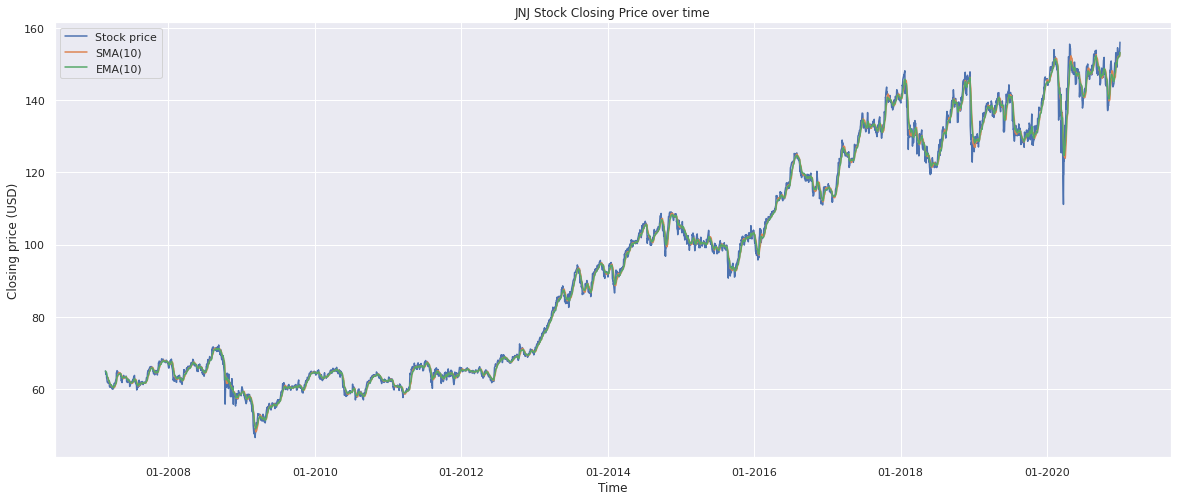

In [157]:
from helpers.plots_helper import plot_prices

ax = plot_prices(data_wrapper['Date'], data_wrapper[price_column], quotation_name=quotation, ma_values=[10], ema_values=[10])

## Volatility and stock prices

In [2]:
quotations = ['AAL', 'AAPL', 'AMZN','CMCSA', 'COST', 'GM', 'GOOG', 'IBM', 'JNJ', 'KO','PEP', 'TSLA', 'WMT', 'XOM']

In [3]:
trading_windows = {
    'day':1,
    'week':5,
    'month':21,
    'year':252,
}

with open("volatility_output.csv", 'w') as f:
    for quot in quotations:
        data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}")
        data_wrapper.compute_features(predict_n=1, thresh_diff=0.005)
        daily_volatility = data_wrapper['Close'].pct_change(1).std()

        f.write(f"{quot},")
        for label, w in trading_windows.items():
            f.write(f"{(daily_volatility * w ** 0.5):.3f} ,")

        f.write('\n')
        

NameError: name 'StocksDataWrapper' is not defined

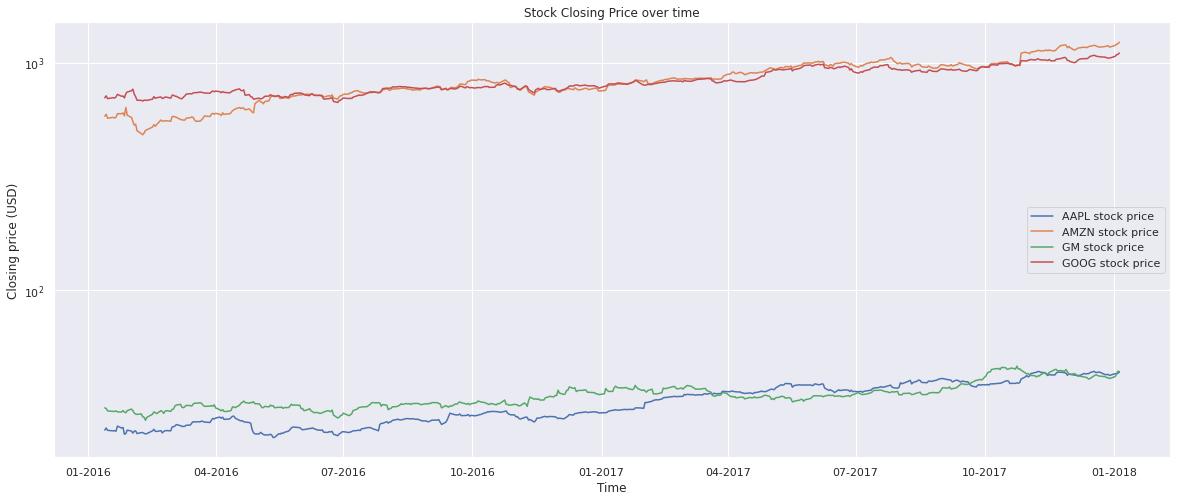

In [210]:
import matplotlib.dates as mdates
import datetime

prices_dict = {}
n_days = 500
for quot in ['AAPL', 'AMZN', 'GM', 'GOOG']:
    data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}")
    prices_dict[quot] = data_wrapper['Close'][-n_days:]
    
date_series = data_wrapper['Date'][-n_days:]        
ax = plt.gca()
ax.set(yscale='log')
ax.set(title=f"Stock Closing Price over time", ylabel='Closing price (USD)', xlabel='Time')
x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in date_series]

formatter = mdates.DateFormatter("%m-%Y")

ax.xaxis.set_major_formatter(formatter)

for quot, prices in prices_dict.items():
    ax.plot(x_values, prices, label=f"{quot} stock price")

    
    
plt.legend(loc='center right')
plt.show()


## ML Experiments

In [11]:
days_predict_feature_set = {
    1:['Volume', 'Close', 'LowLen', 'Difference', 'BG_L_Band', 'GAP', 'MACD_diff'],
    5:['Volume', 'Close', 'LowLen', 'Difference', 'SMA(20) - SMA(10)', 'BG_H_Band_Indicator', 'MACD'],
    10:['Volume', 'Close', 'BodyLen', 'Difference', 'SMA(20) - SMA(10)', 'EMA_Diff', 'MACD_diff'],
    20:['Volume', 'Close', 'LowLen', 'Difference', 'EMA(14)', 'BG_H_Band', 'MACD_diff'],
    50:['Volume', 'Close', 'LowLen', 'Difference', 'BG_L_Band','GAP','MACD_diff'],
}

In [276]:
quot = 'AAL'
predict_n = 20

In [277]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [278]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}", compute_features=True, 
                                           predict_n=predict_n, thresh_diff=None, normalize=True)


X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                             y_column='NextPrice', 
                                                             features_list=days_predict_feature_set[predict_n])



reg = LinearRegression(normalize=False, fit_intercept=True)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

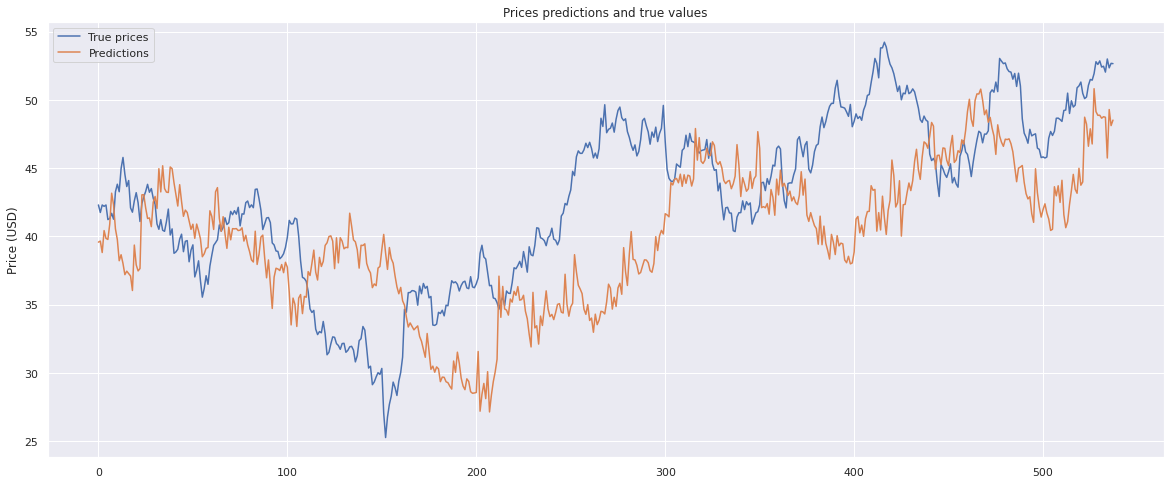

In [279]:
from helpers.plots_helper import plot_predictions

scaled_preds = data_wrapper.get_unscaled_values(y_pred, 'Close')
scaled_labels = data_wrapper.get_unscaled_values(y_test, 'Close')

plot_predictions(scaled_labels, scaled_preds)
plt.show()

In [280]:
seq_len = 5
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds
from trainers.keras_regression_trainer import KerasRegressionTrainer
from models.keras_lstm_model import LSTMModel
import tensorflow as tf


config_dict = dict(
    quotation=quotation,
    predict_n = predict_n,
    features=days_predict_feature_set[predict_n],
    learning_rate = 0.01,
    batch_size = 32,
    sequence_length=seq_len,
    n_epochs = 100,
    n_splits = 5,
    val_size = 0.2,
)

In [281]:
X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2,
                                                             y_column='NextPrice', sequences=True, seq_len=5,
                                                             features_list=days_predict_feature_set[predict_n])
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(config_dict['batch_size'])
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(config_dict['batch_size'])

model = LSTMModel(config_dict, seq_len, len(days_predict_feature_set[predict_n]), output_dim=1,
                  learning_rate=config_dict['learning_rate'], loss='mae', metrics=['accuracy'])
trainer = KerasRegressionTrainer(model, use_wandb=True, project_label="PlotsReport")
trainer.train(train_set)

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/PlotsReport/runs/3pc0fr5e


{}

In [282]:
y_pred = model.predict(X_test)

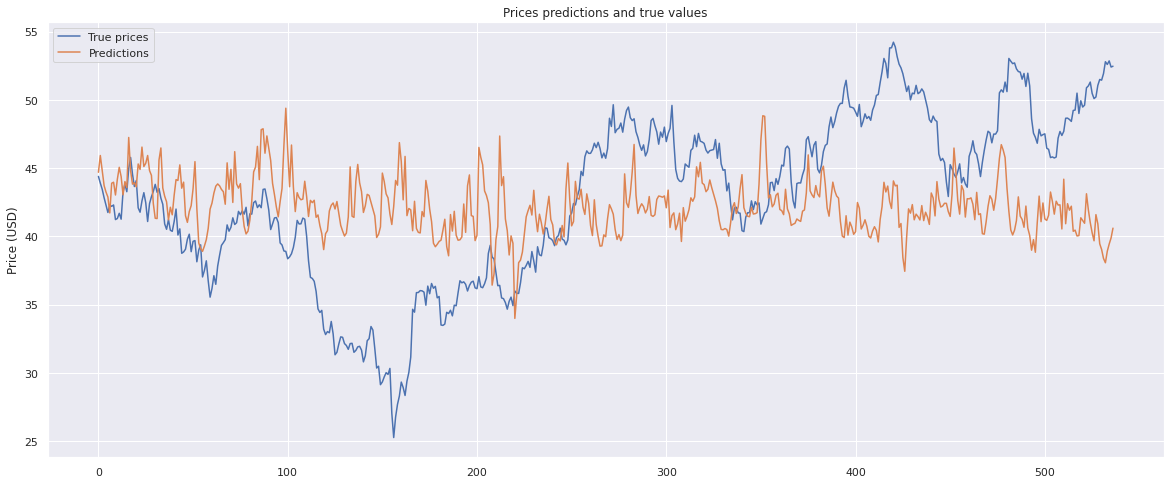

In [283]:
from helpers.plots_helper import plot_predictions

scaled_preds = data_wrapper.get_unscaled_values(y_pred.squeeze(), 'Close')
scaled_labels = data_wrapper.get_unscaled_values(y_test, 'Close')

plot_predictions(scaled_labels, scaled_preds)
plt.show()

In [7]:
from torch.utils.data import DataLoader
from datasets.torch_datasets import StocksDataset
from models.pytorch_linear_model import LinearModel
from trainers.pytorch_classification_trainer import PytorchClassificationTrainer
from trainers.pytorch_regression_trainer import PytorchRegressionTrainer
from datasets.stocks_data_wrapper import StocksDataWrapper

In [142]:
quot = 'TSLA'
days_predict_feature_set = {
    1:['Volume', 'Close', 'LowLen', 'Difference', 'BG_L_Band', 'GAP', 'MACD_diff'],
    5:['Volume', 'Close', 'LowLen', 'Difference', 'SMA(20) - SMA(10)', 'BG_H_Band_Indicator', 'MACD'],
    10:['Volume', 'Close', 'BodyLen', 'Difference', 'SMA(20) - SMA(10)', 'EMA_Diff', 'MACD_diff'],
    20:['Volume', 'Close', 'LowLen', 'Difference', 'EMA(14)', 'BG_H_Band', 'MACD_diff'],
    50:['Volume', 'Close', 'LowLen', 'Difference', 'BG_L_Band','GAP','MACD_diff'],
}
THRESH_DIFF = 0.005
predict_n = 5

In [144]:
import torch.nn as nn
import torch
device = 'cuda'

data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}", 
                                           compute_features=True, 
                                           predict_n=predict_n, 
                                           thresh_diff=THRESH_DIFF, normalize=True)
features_list = days_predict_feature_set[predict_n]

X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                             y_column='Next', 
                                                             features_list=days_predict_feature_set[predict_n])

n_classes = len(np.unique(y_train))
      
train_dataset = StocksDataset(X_train,y_train)
test_dataset = StocksDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

config = dict(
    lr=1e-5,
    loss=nn.CrossEntropyLoss,
    n_epochs=100,
    optimizer=torch.optim.Adam,
)
model = LinearModel(config, input_dim=X_train.shape[1], output_dim=n_classes, device=device)
trainer = PytorchClassificationTrainer(model, device=device, use_wandb=False, project_label="Pipeline")
trainer.train(dataloader=train_dataloader)


metrics = trainer.evaluate(test_dataloader)
print(metrics)

{'acc': 0.42337164750957856, 'f1': 0.38983107456172905}


## Explanations 

In [145]:
# helper for predicting scores
def predict_batch(sample):
    probability_model = nn.Sequential(
        *model.model,
        nn.Softmax(1),
    )
    with torch.no_grad():
        model.eval()
        output = probability_model(torch.Tensor(sample).to(device))
        return output.cpu().numpy()

predict_batch(np.array([X_train[1]]))

array([[0.36832964, 0.2393235 , 0.39234692]], dtype=float32)

In [146]:
from helpers.explainer import explain_model, plot_explanation
explanations = explain_model(predict_batch, X_train, y_train, 
                             data_columns=days_predict_feature_set[predict_n], 
                             class_names=['lower','stay', 'higher'], n_exps=20, mode='classification')

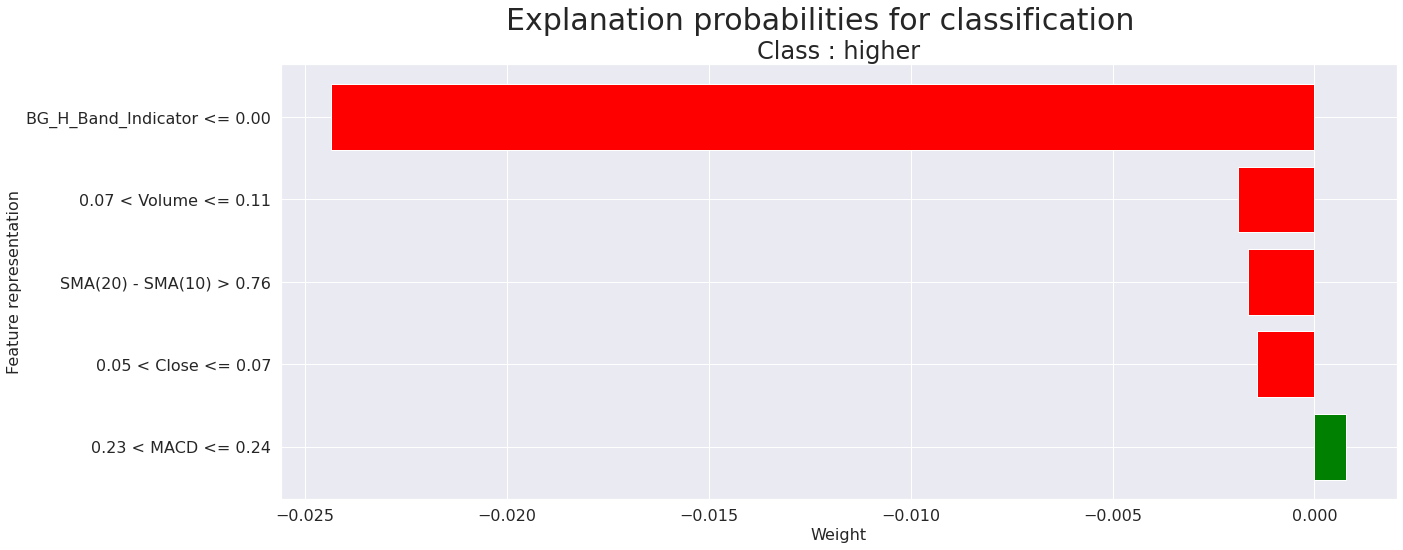

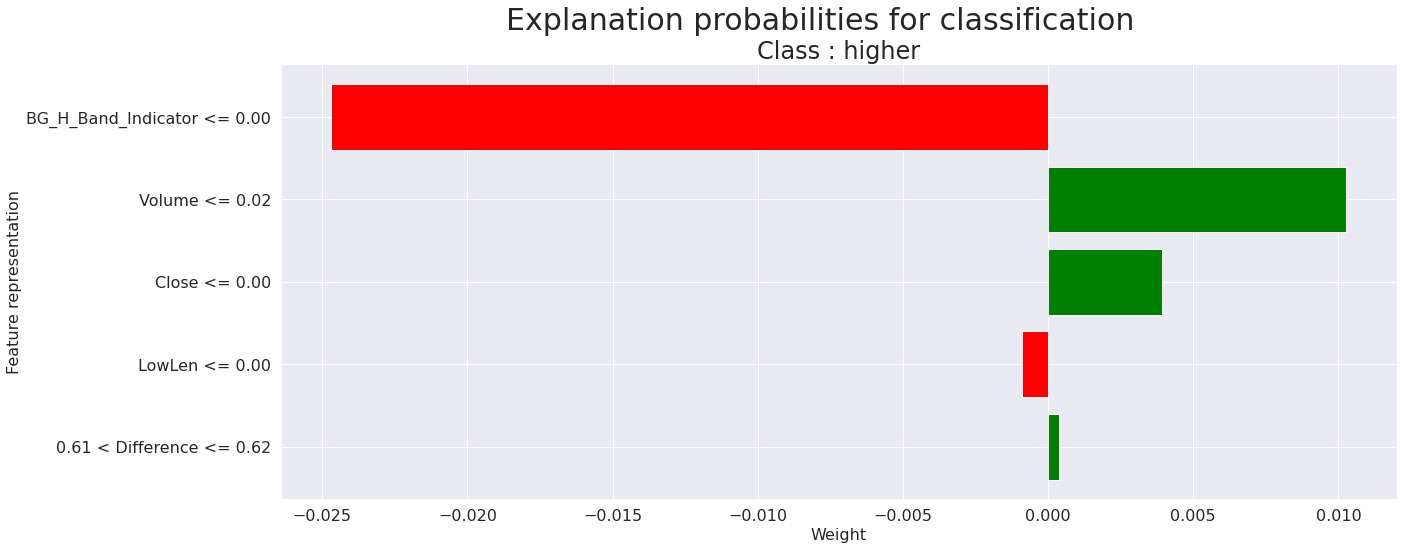

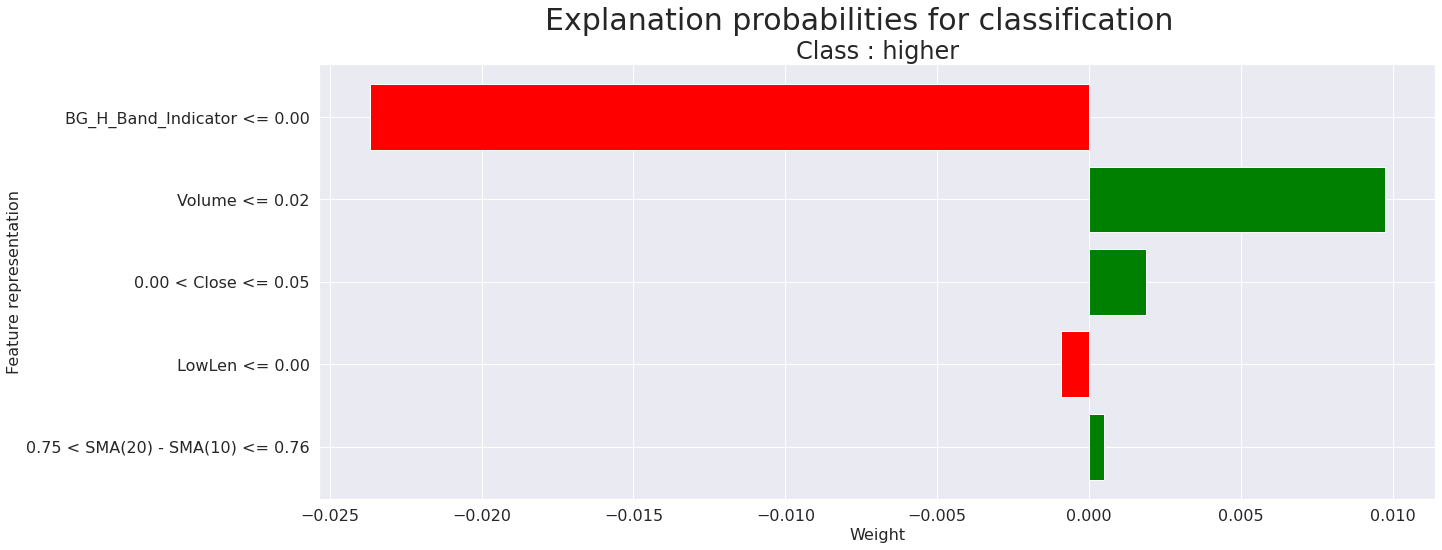

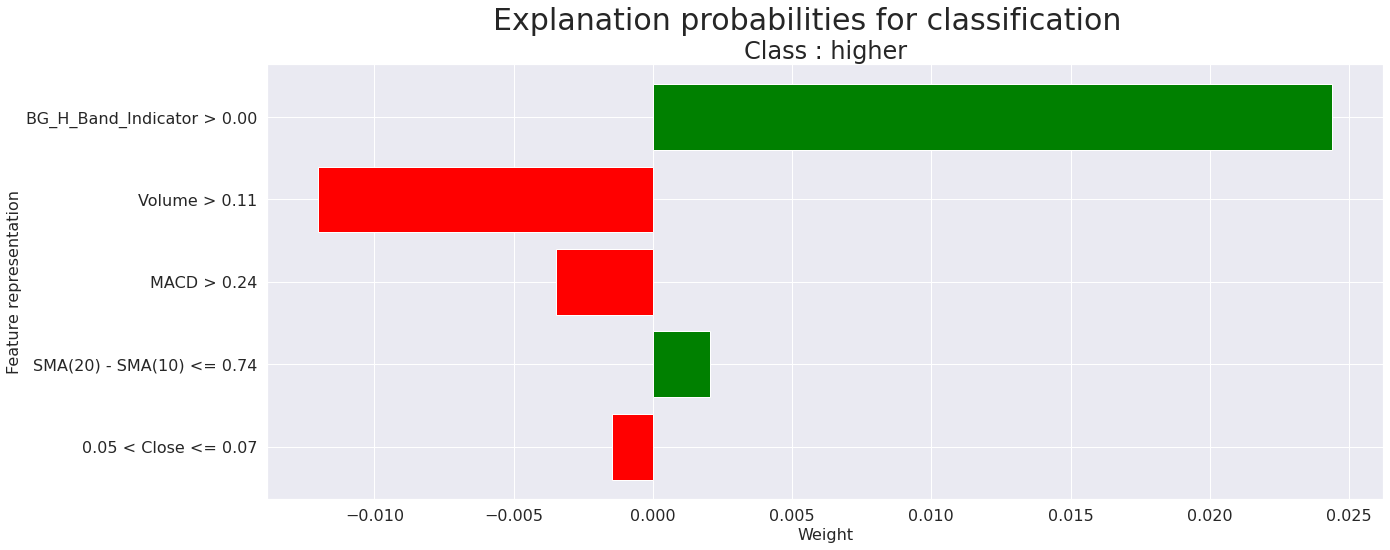

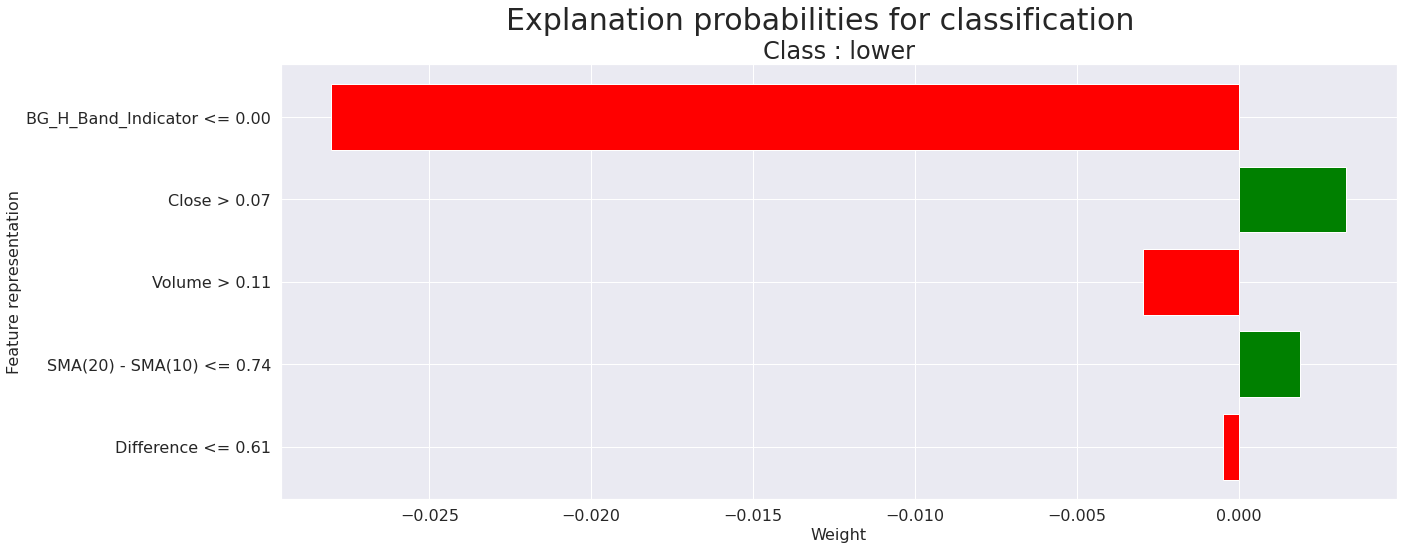

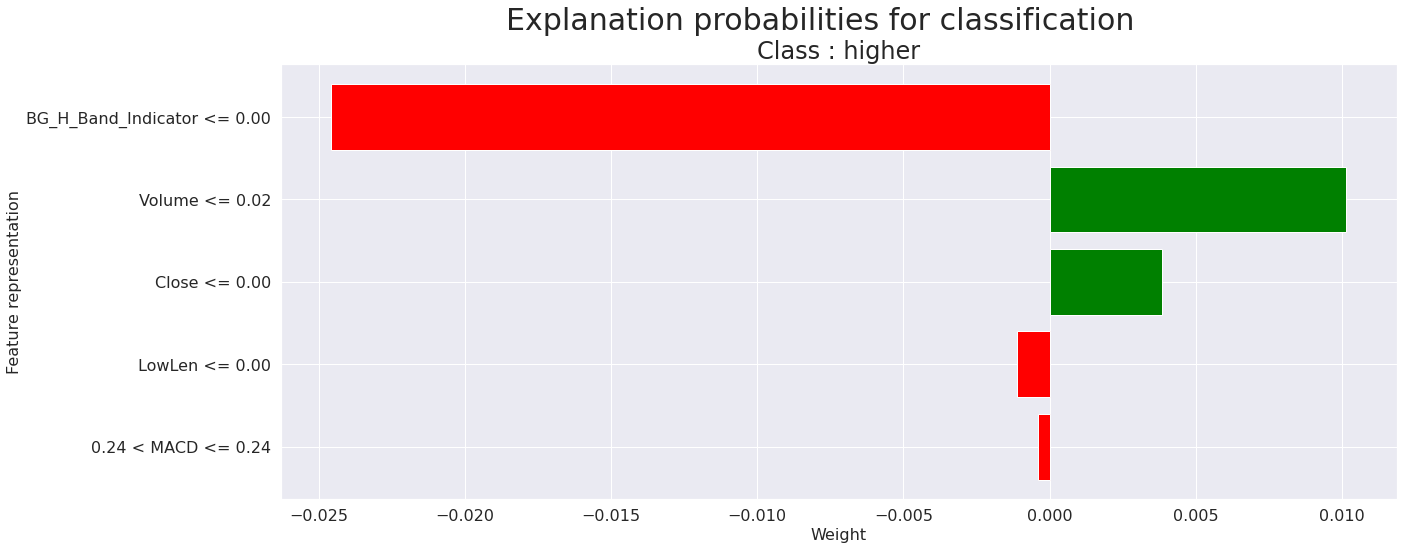

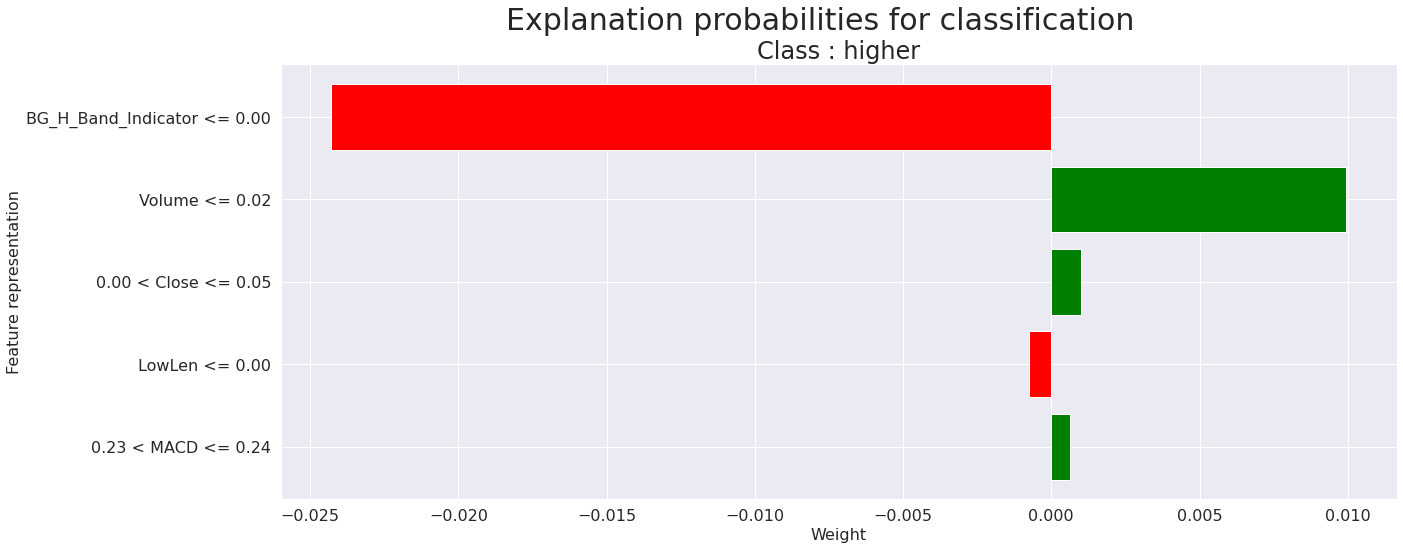

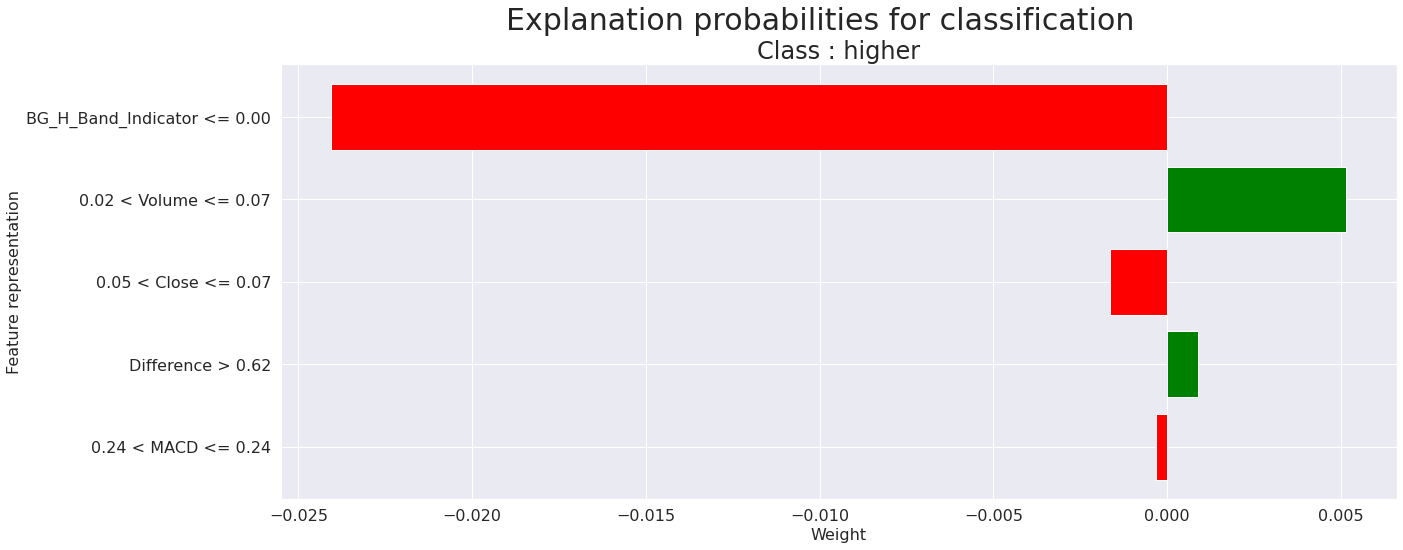

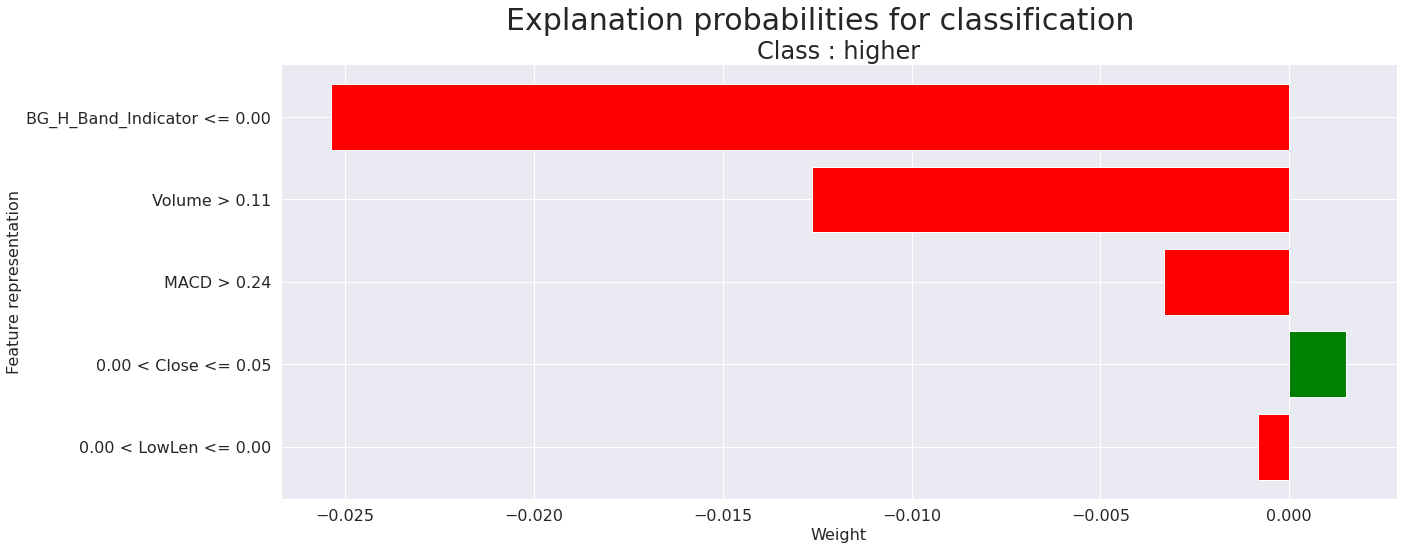

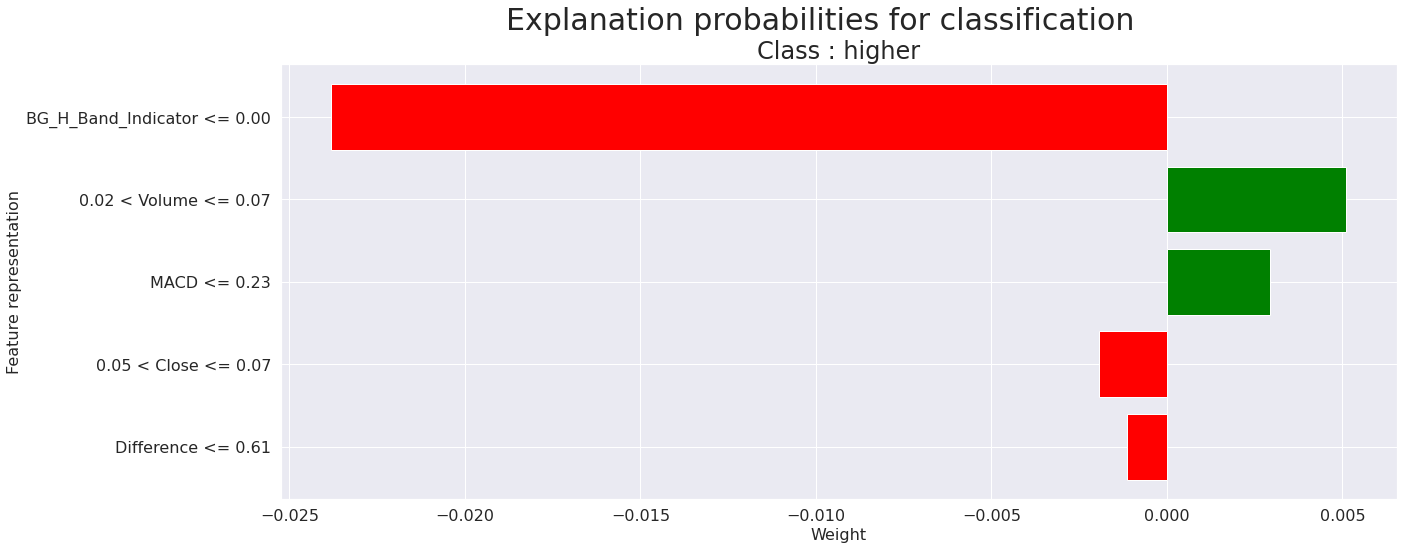

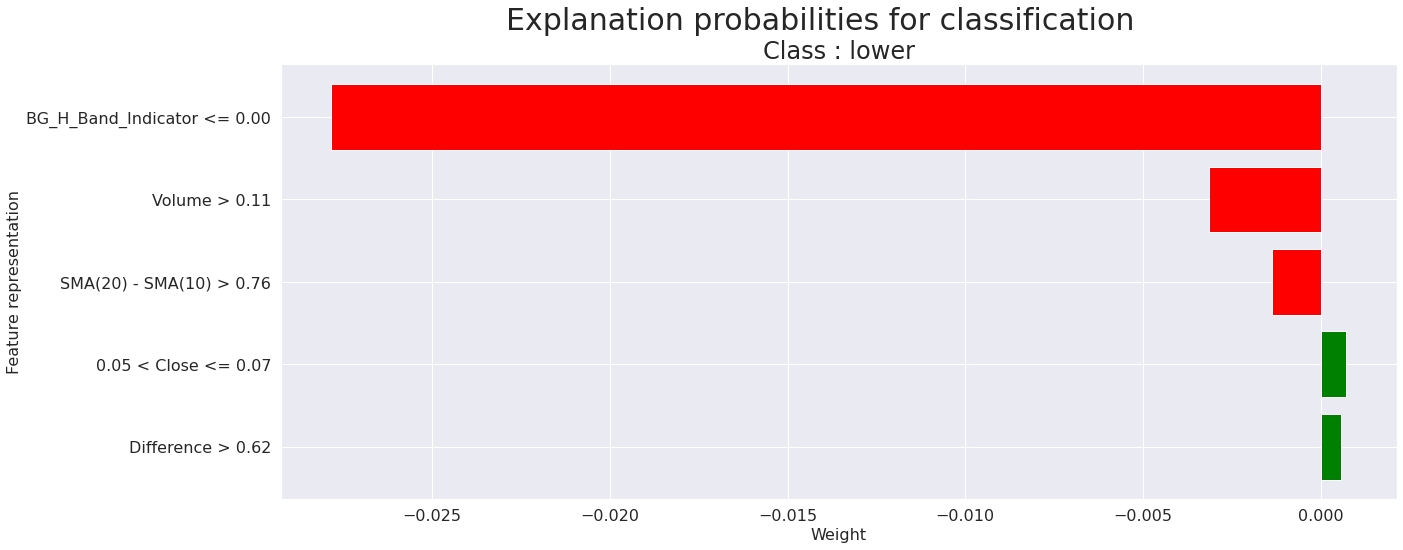

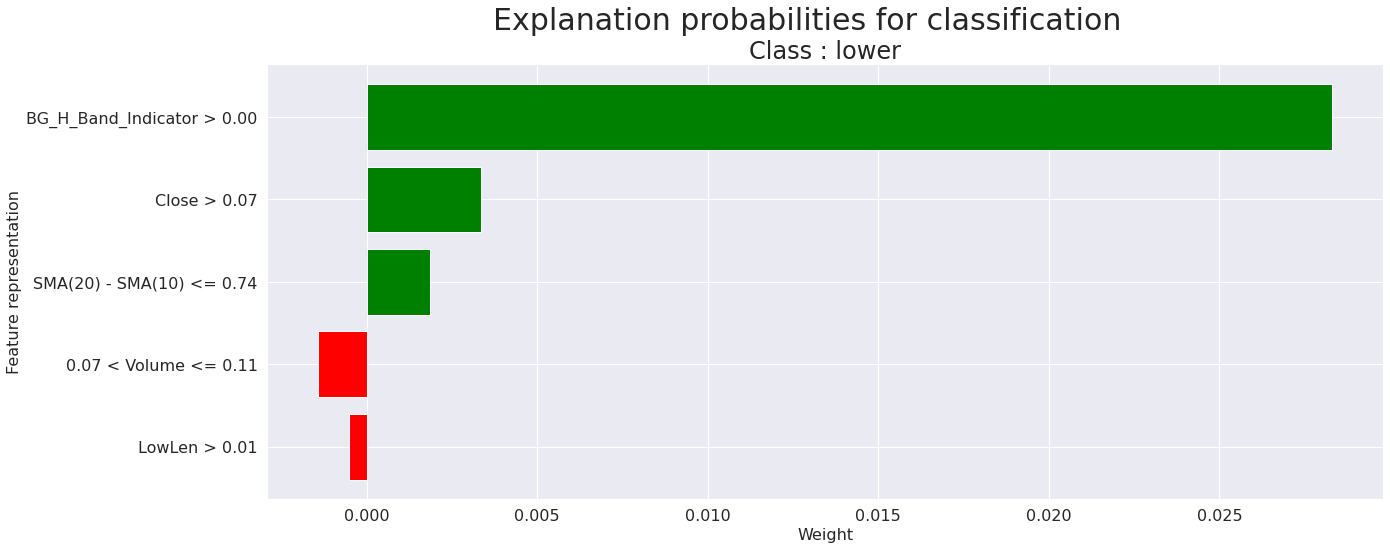

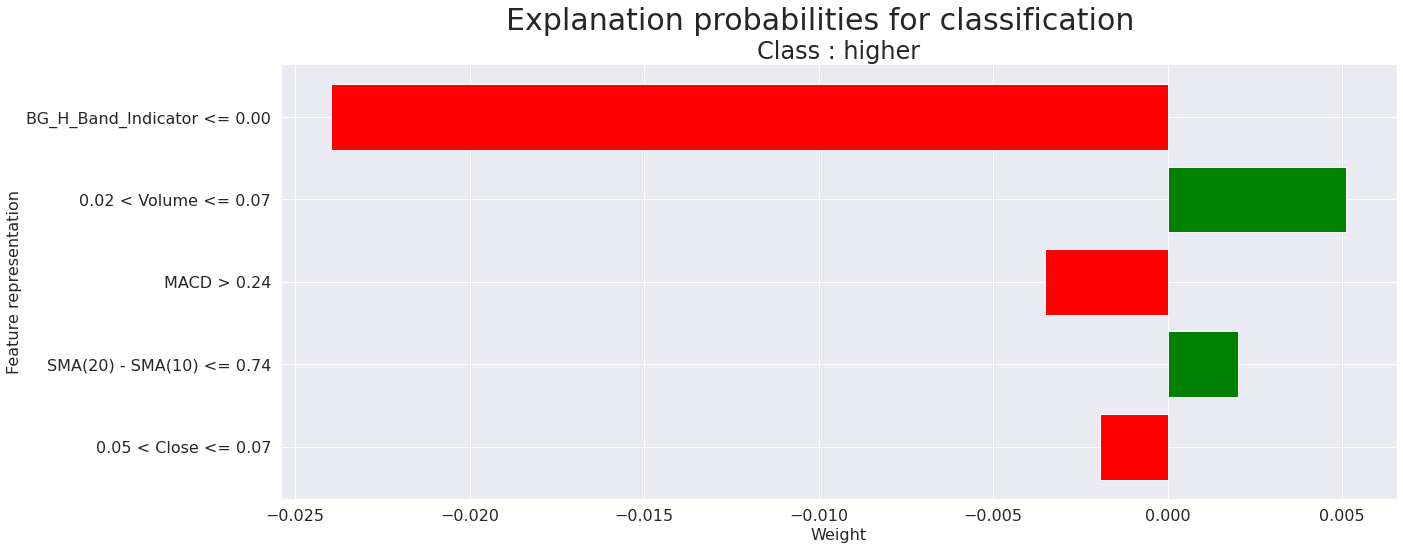

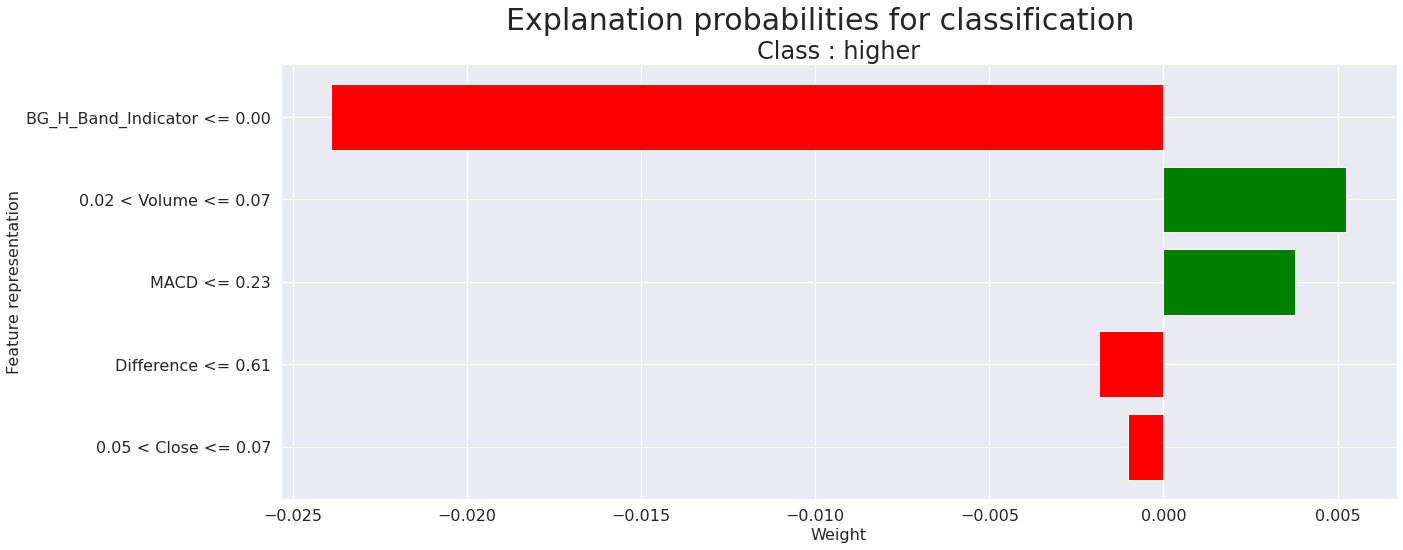

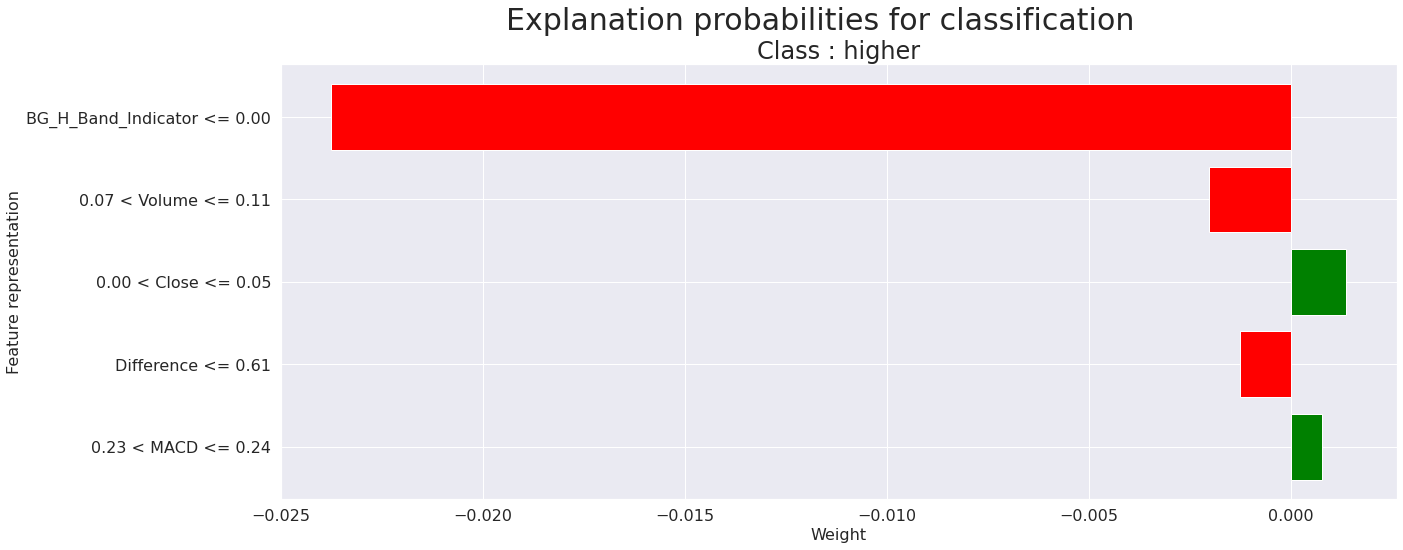

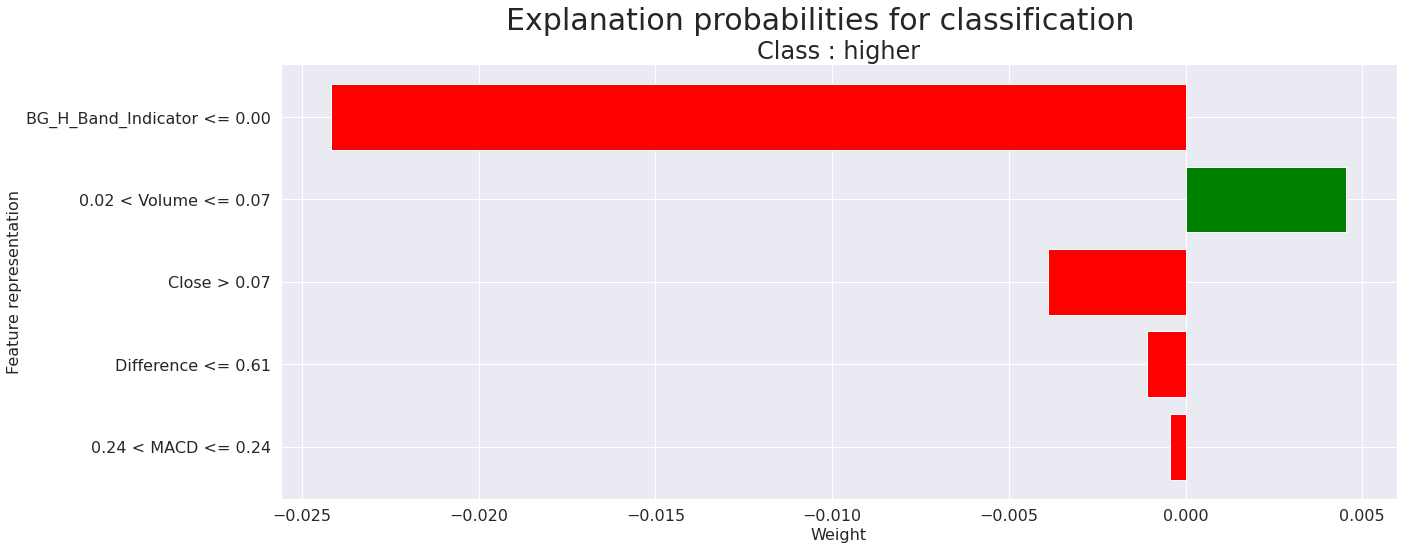

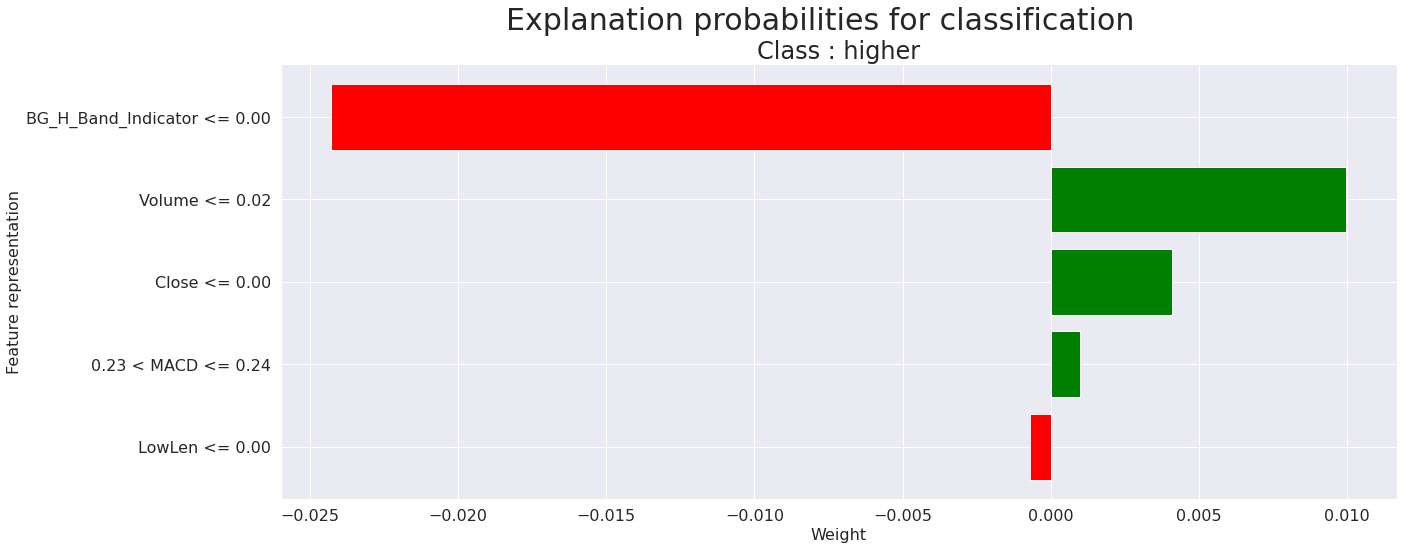

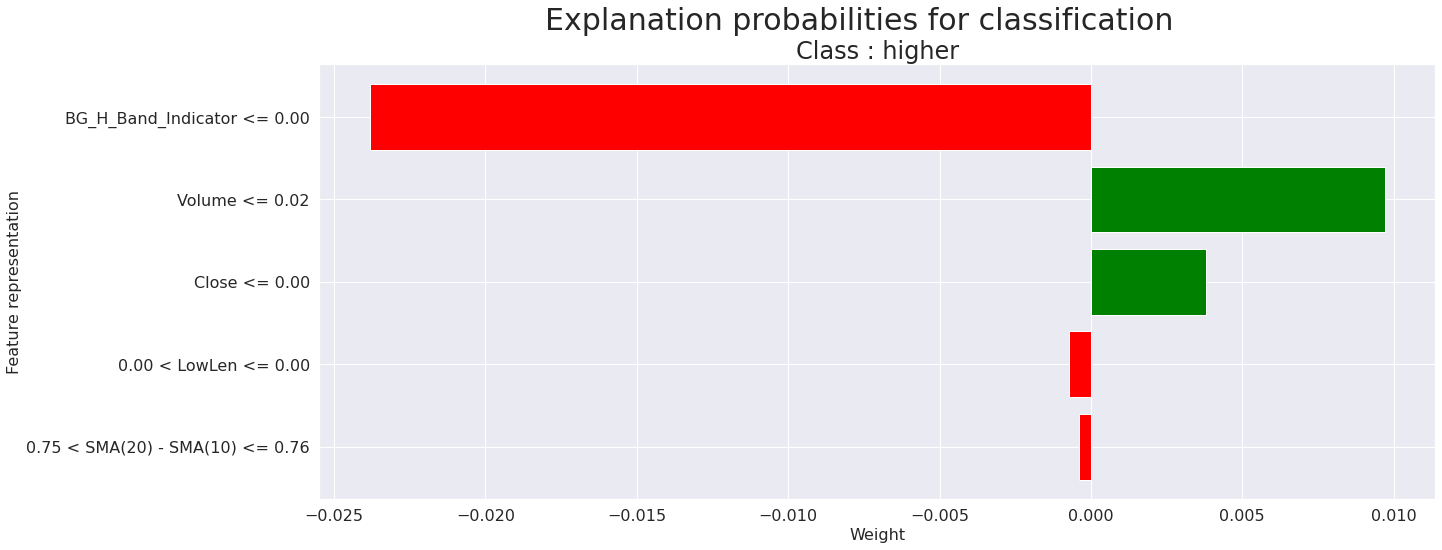

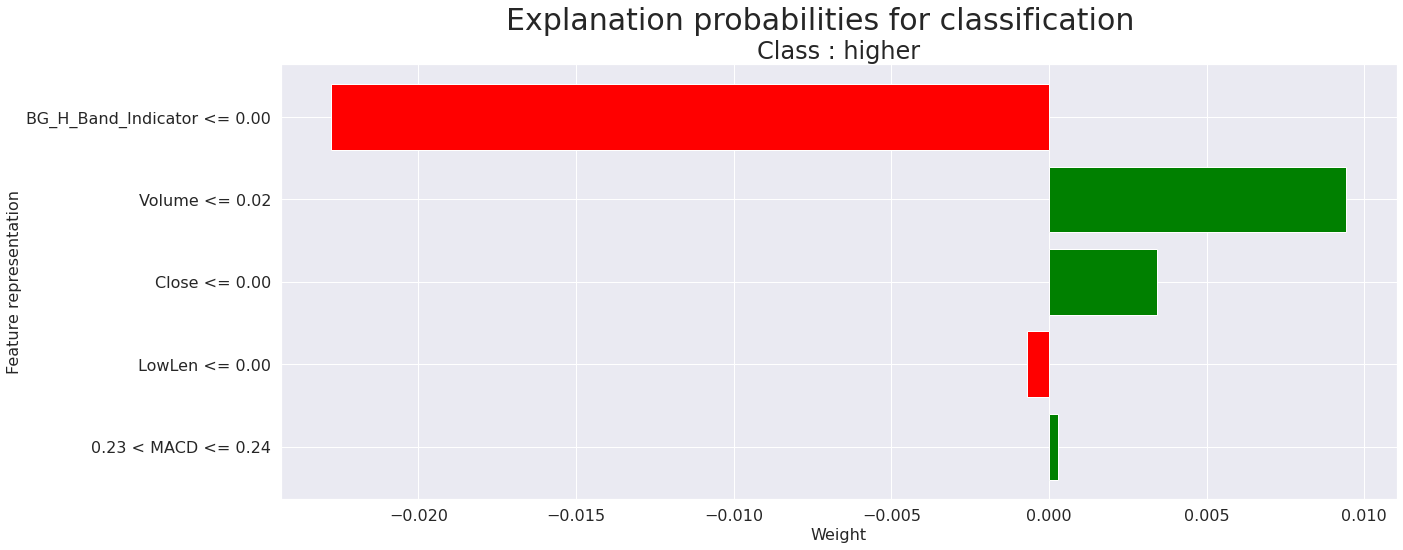

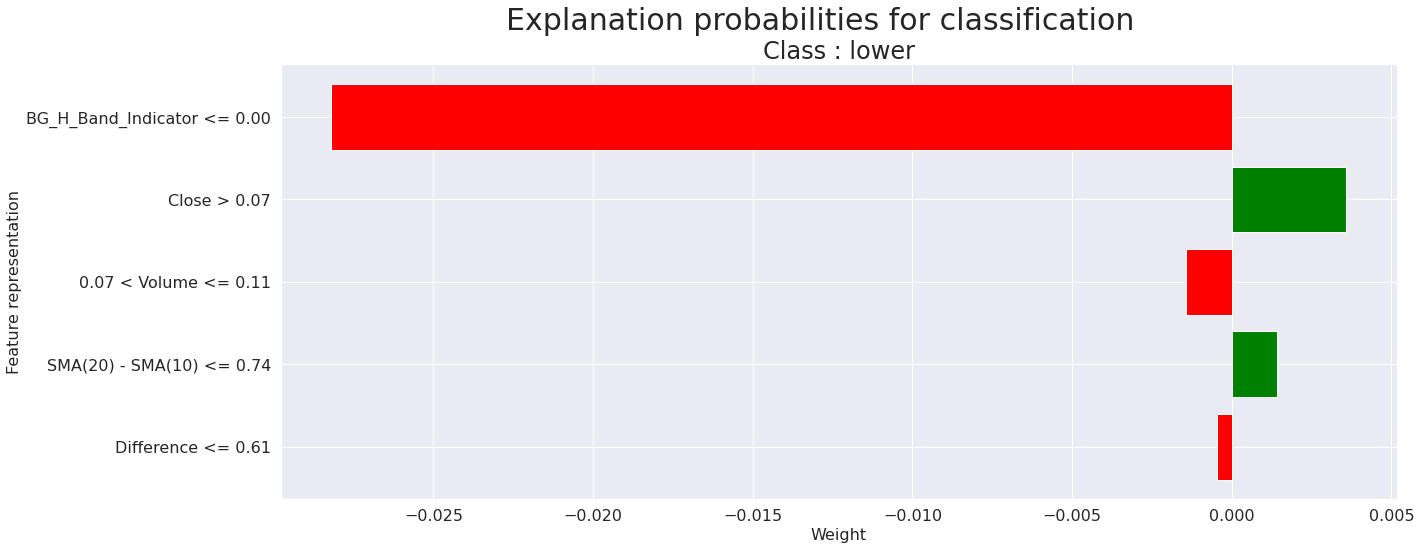

In [147]:
for exp in explanations:
    ax = plot_explanation(exp, class_names=['lower', 'stay', 'higher'])

In [153]:
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

quot='JNJ'
predict_n=5



data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}", 
                                           compute_features=True, 
                                           predict_n=predict_n, 
                                           thresh_diff=THRESH_DIFF, normalize=True)

X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                             y_column='NextPrice', 
                                                             features_list=days_predict_feature_set[predict_n])

#lr = LogisticRegression(C=10.0, penalty='l2', fit_intercept=True)
lr = LinearRegression(normalize=False, fit_intercept=True)
lr.fit(X_train, y_train)

"""explanations = explain_model(lr.predict, X_train, y_train, 
                             data_columns=days_predict_feature_set[predict_n], 
                             class_names=['lower','higher'], n_exps=2, mode='classification')"""

explanations = explain_model(lr.predict, X_train, y_train, 
                             data_columns=days_predict_feature_set[predict_n], 
                             class_names=['lower','higher'], n_exps=20, mode='regression')

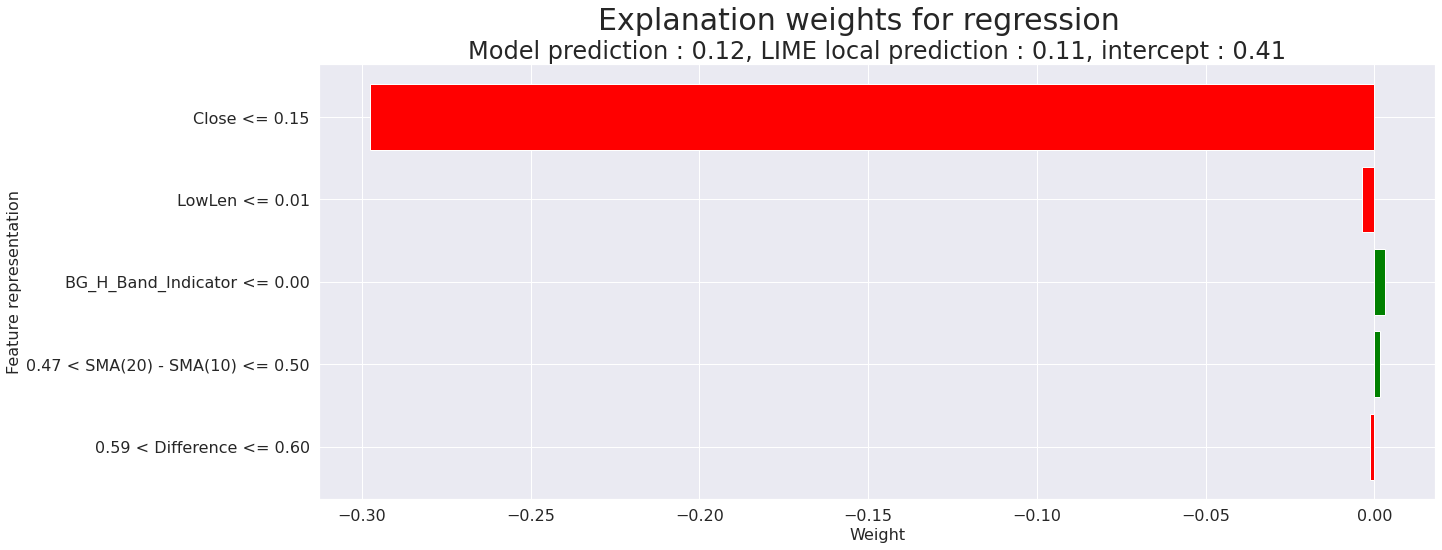

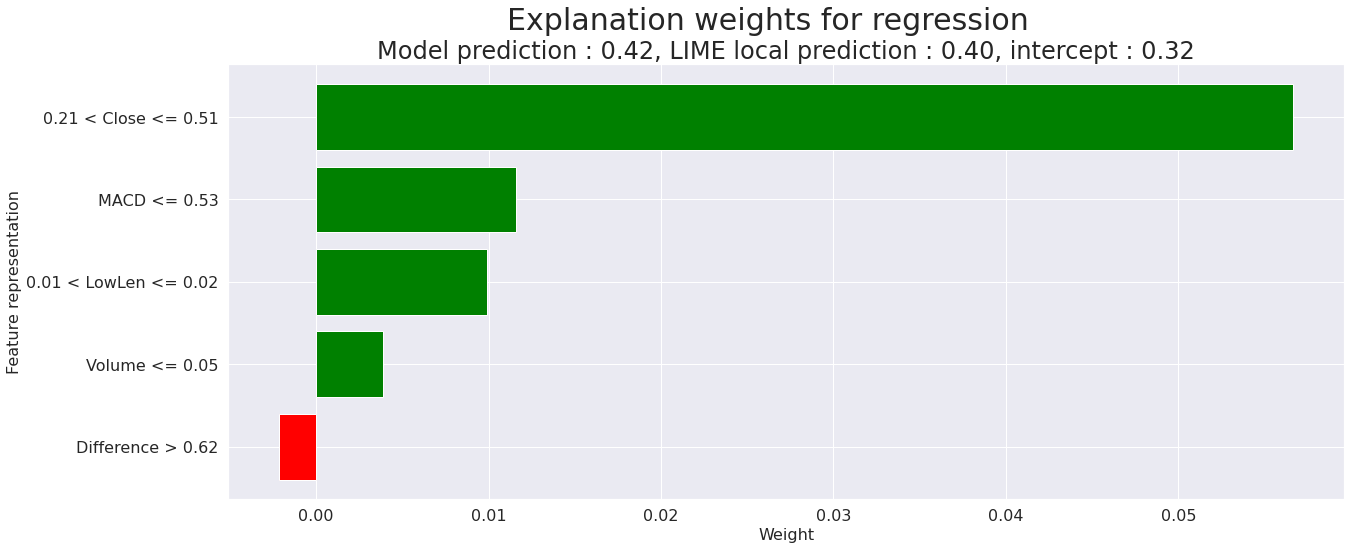

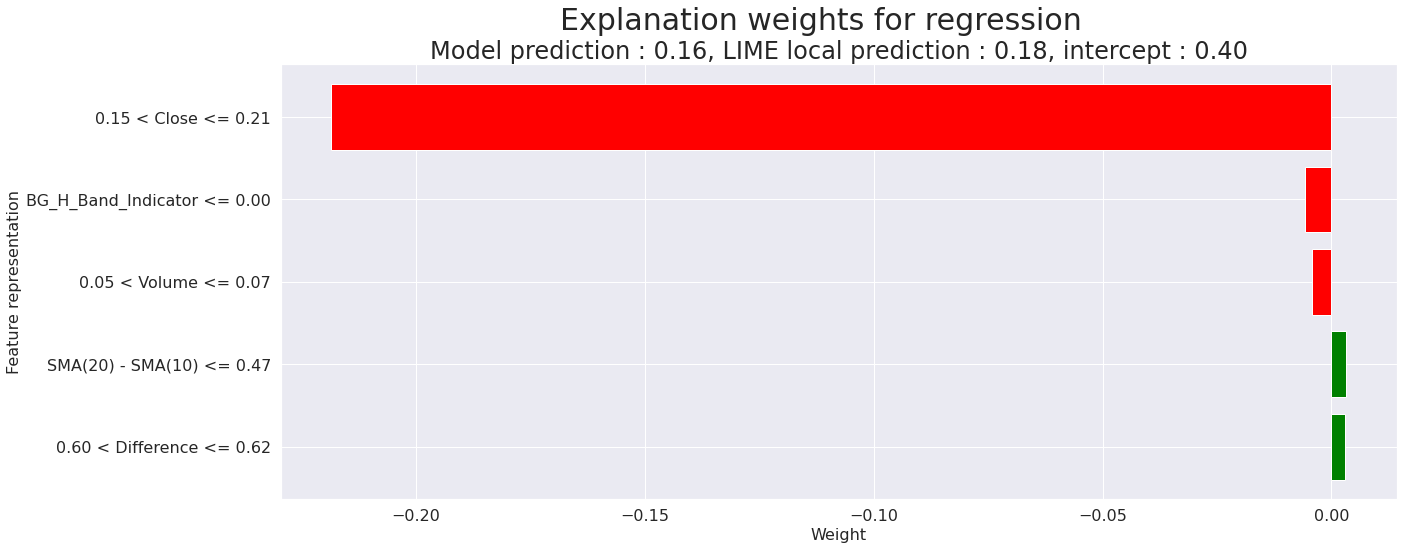

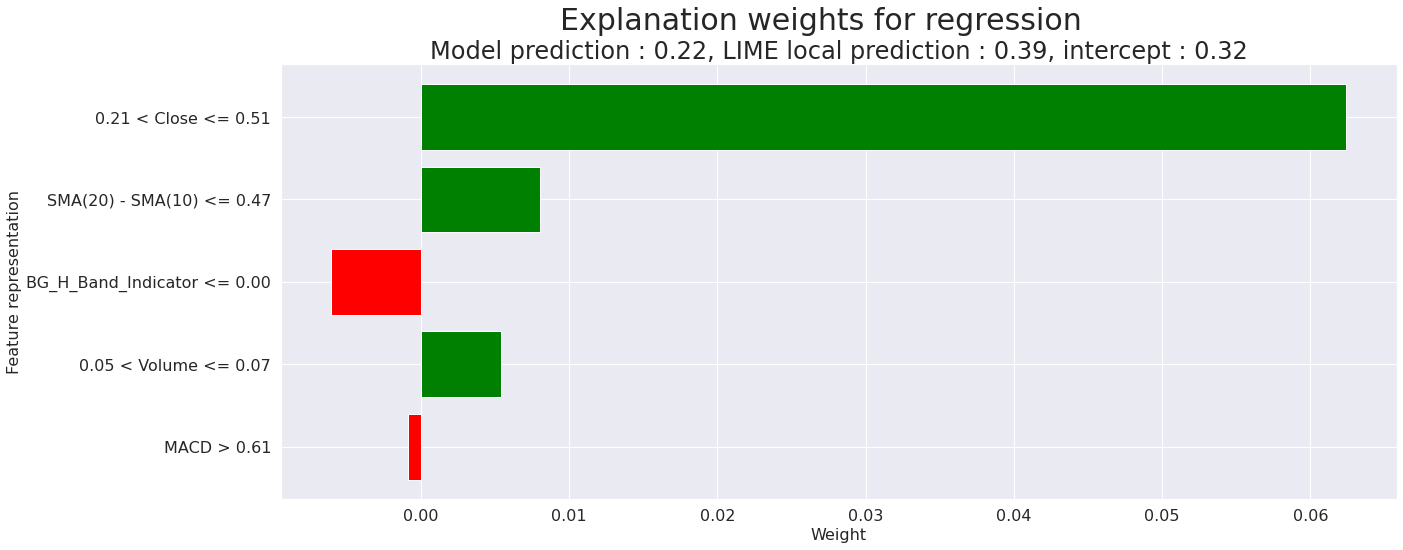

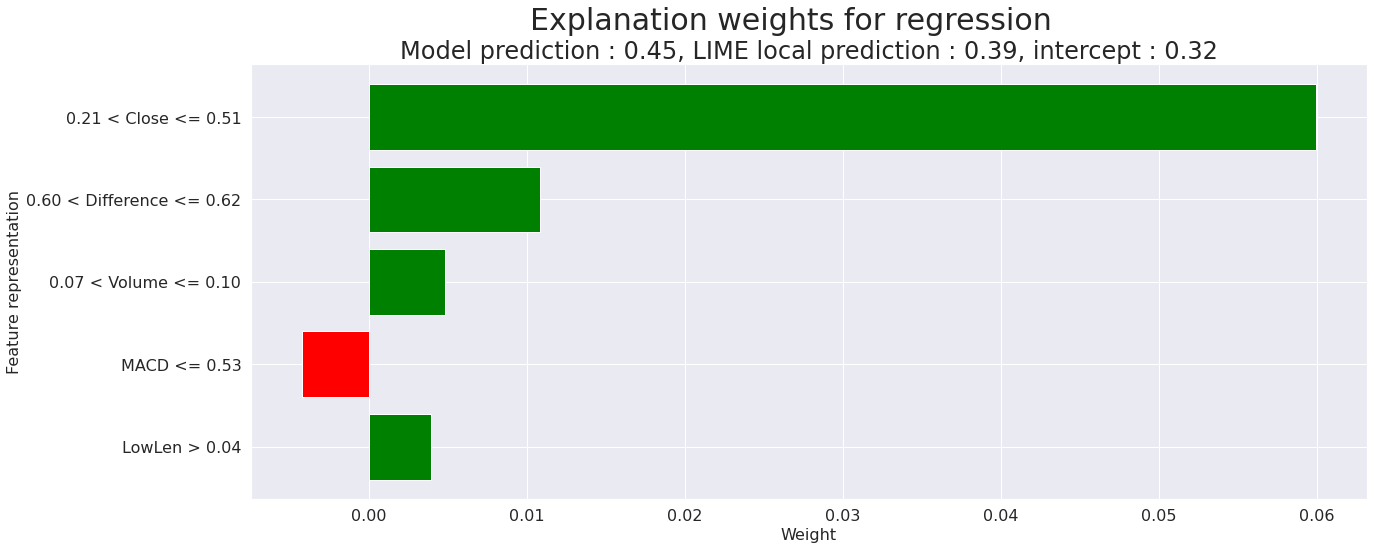

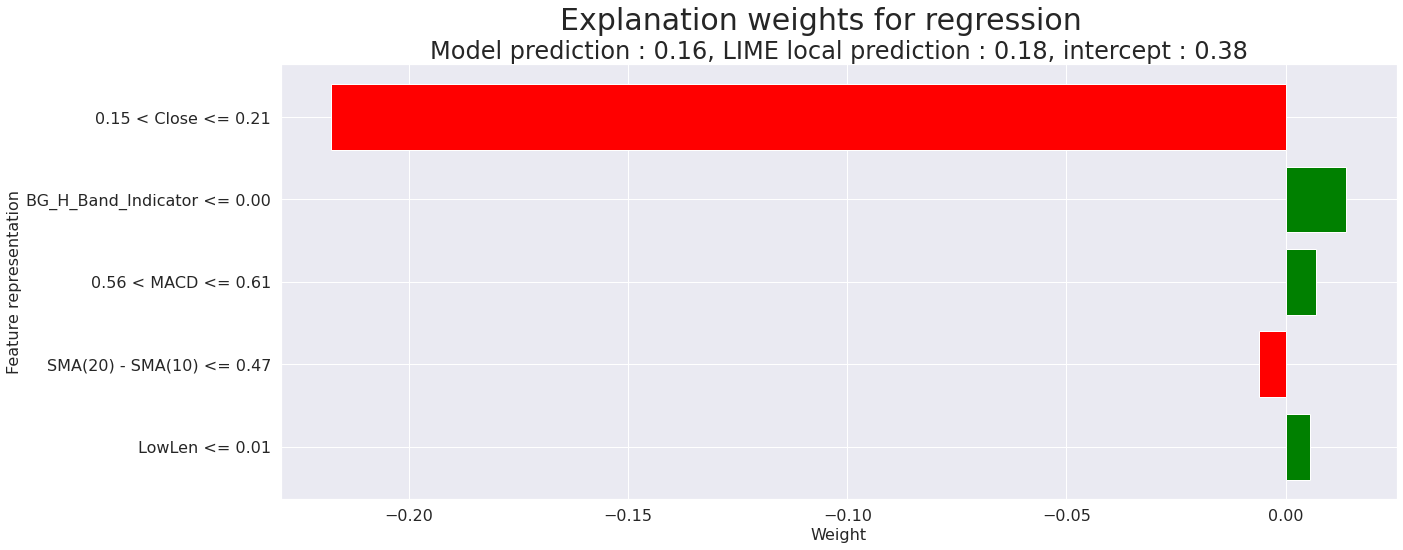

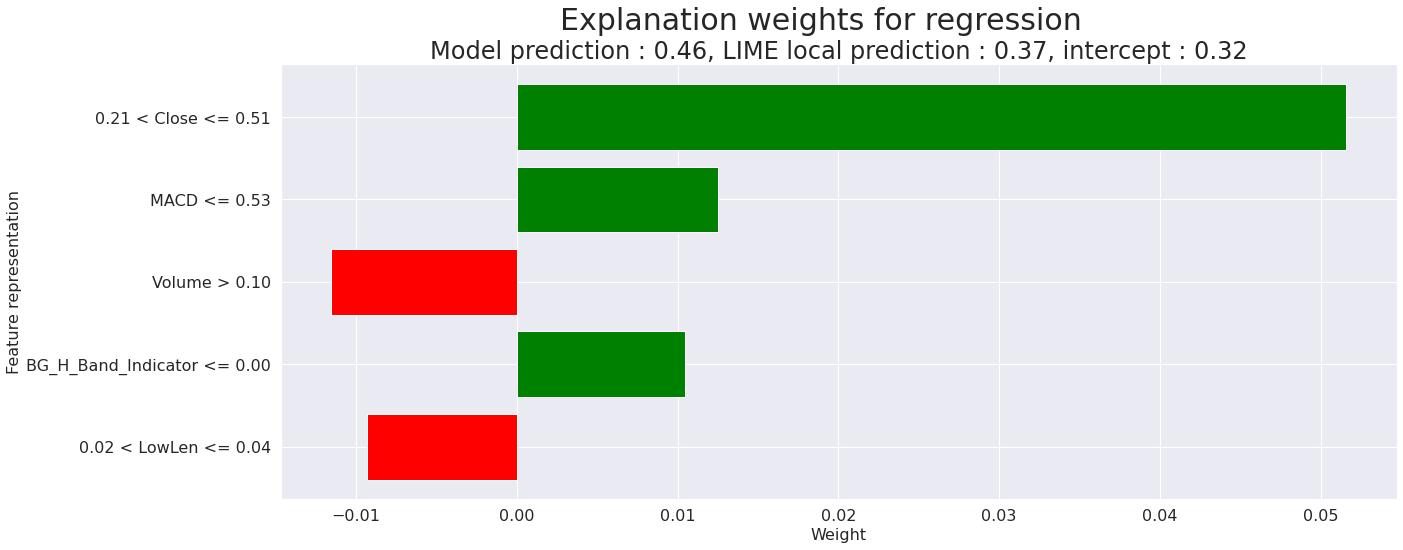

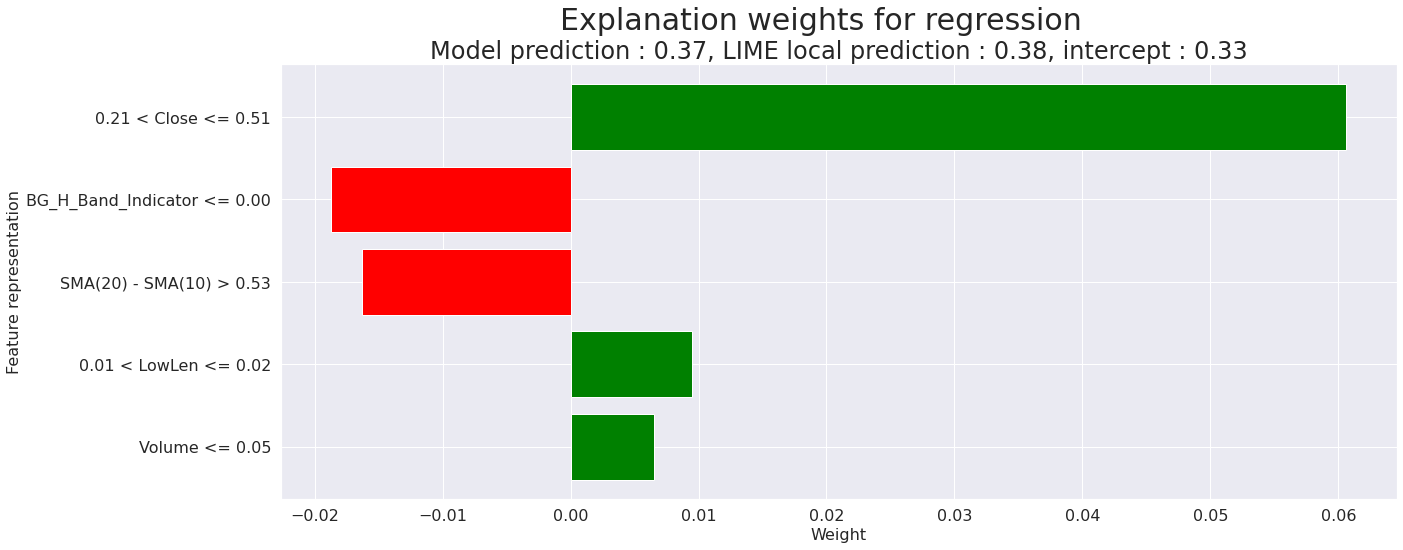

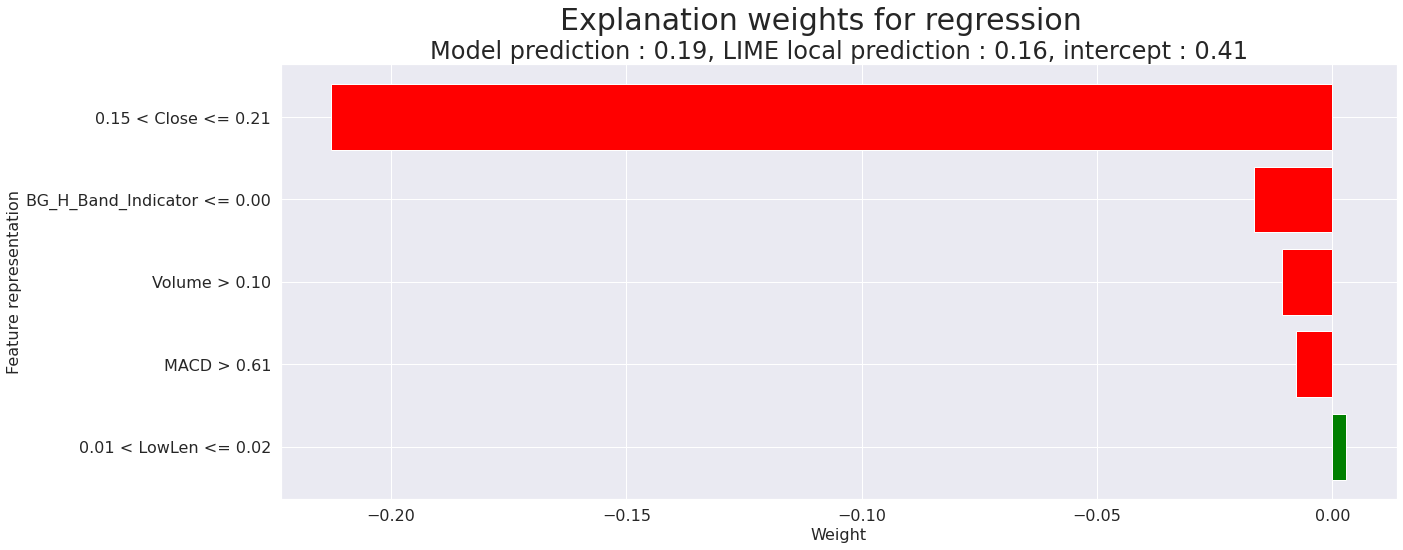

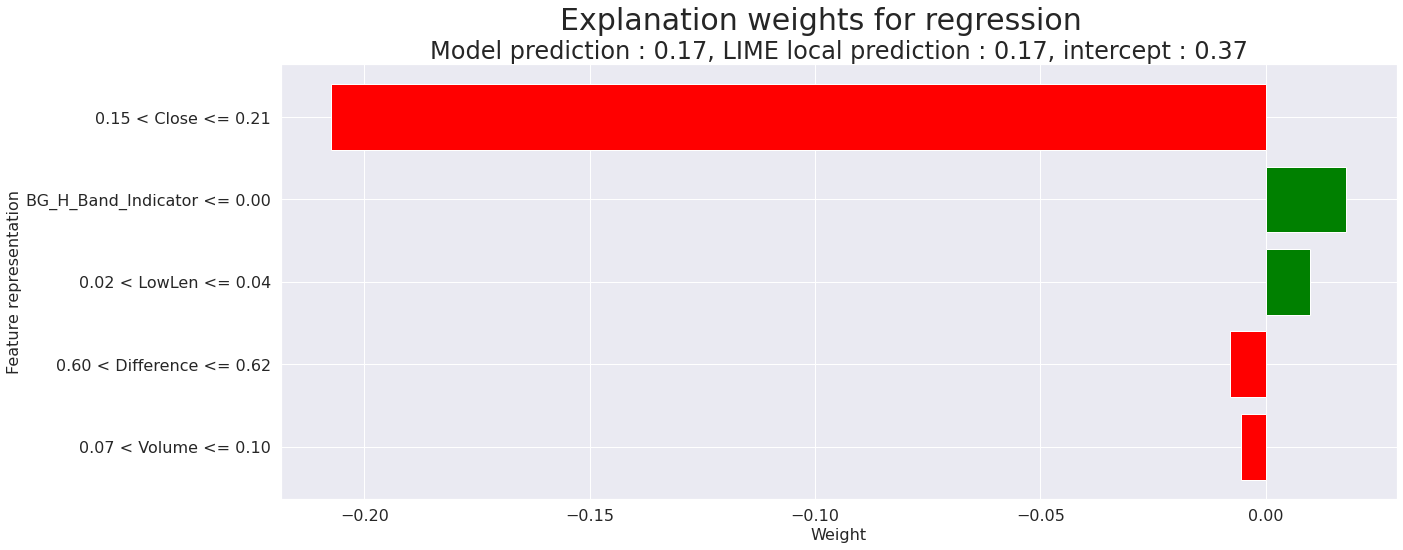

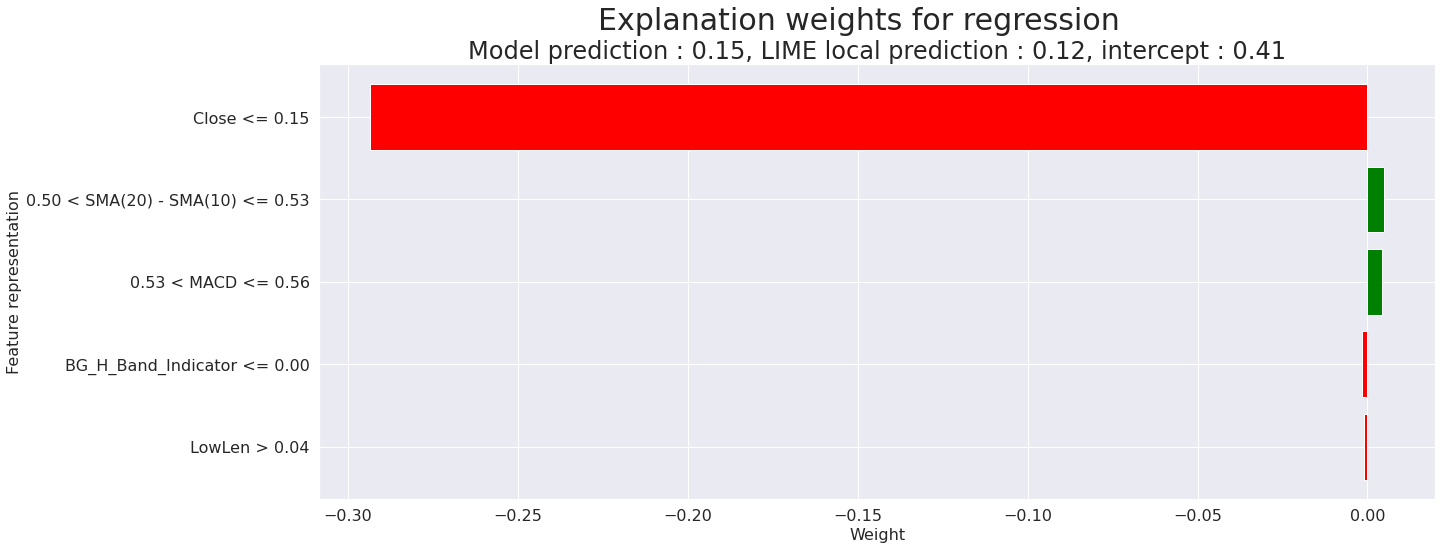

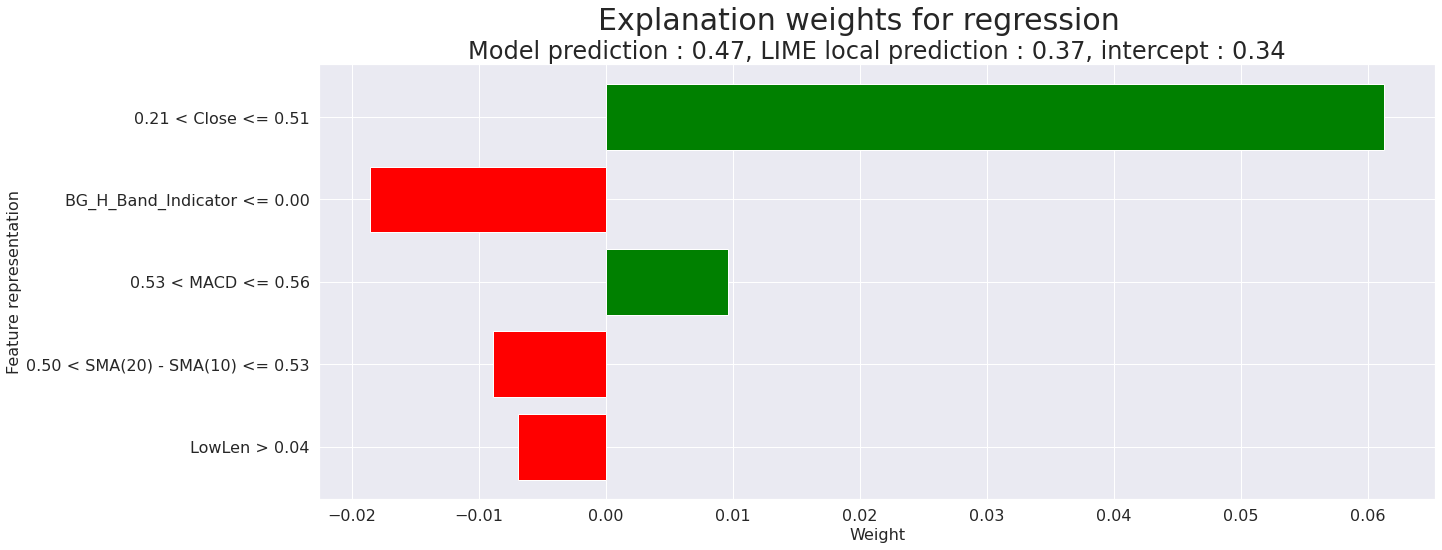

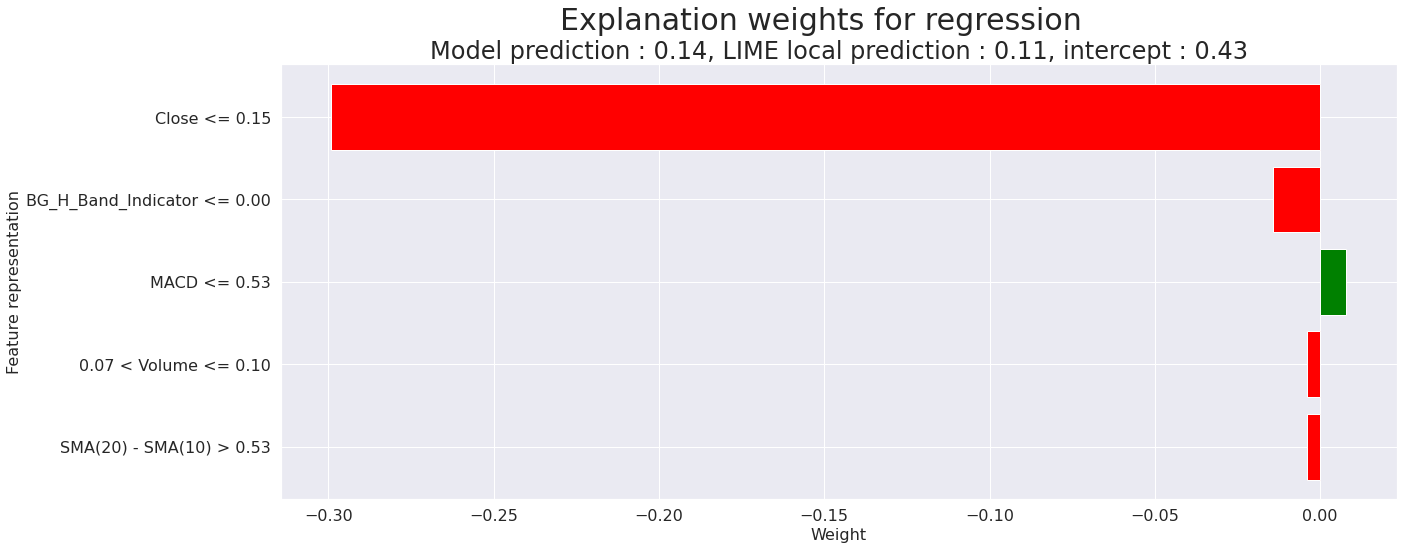

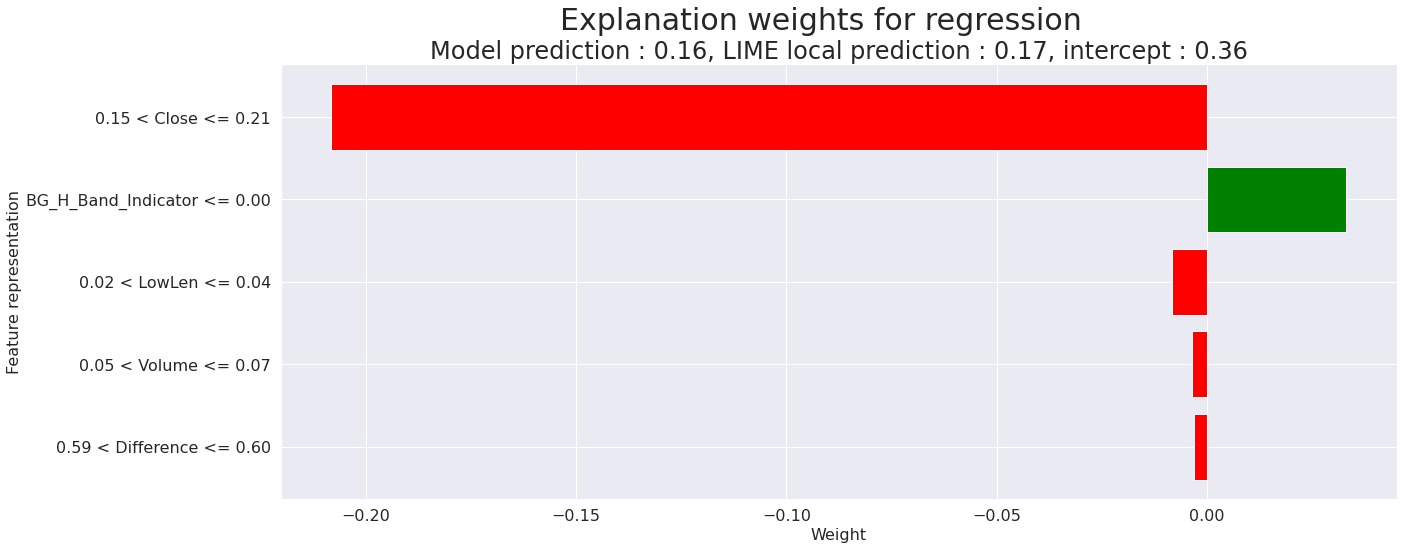

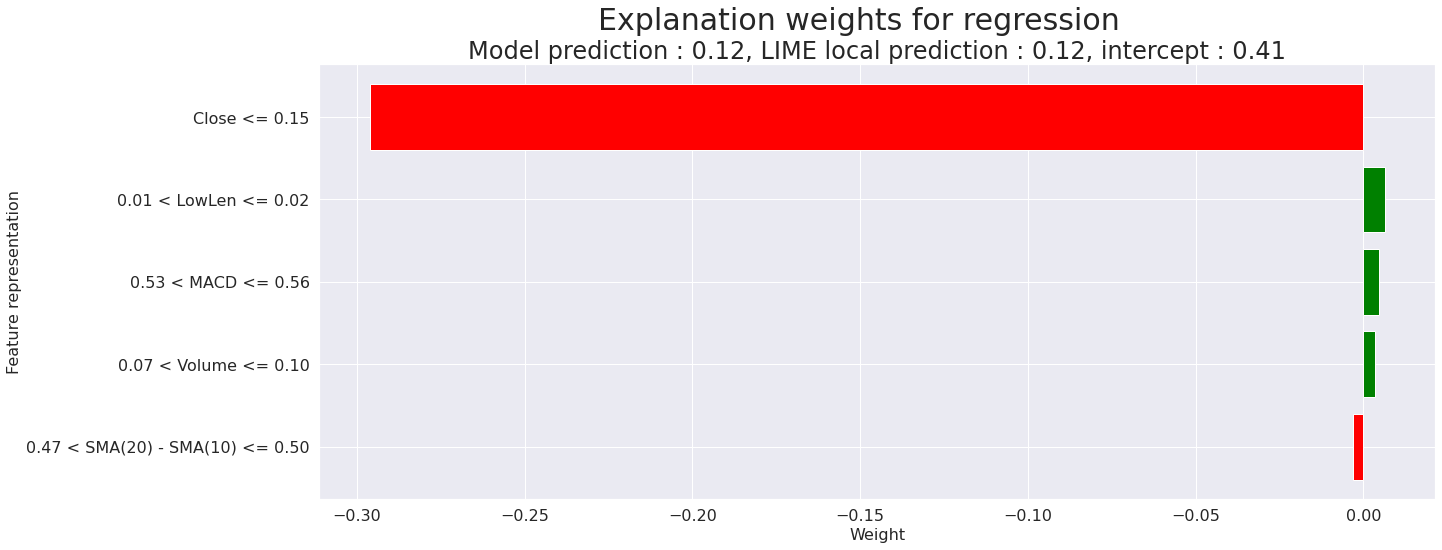

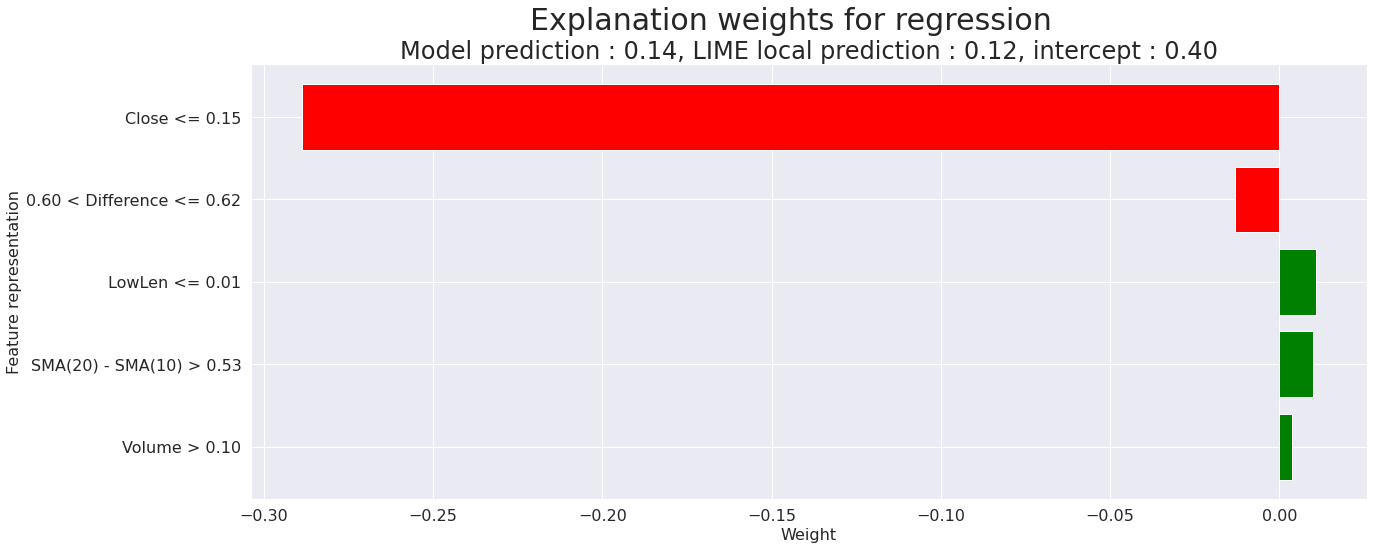

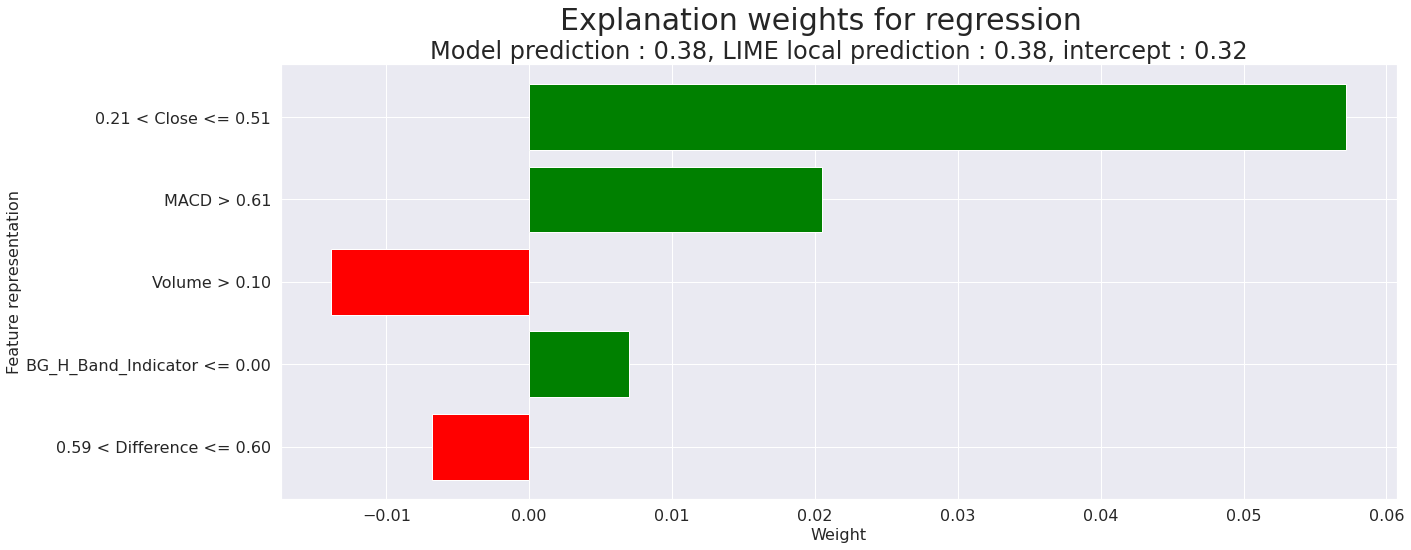

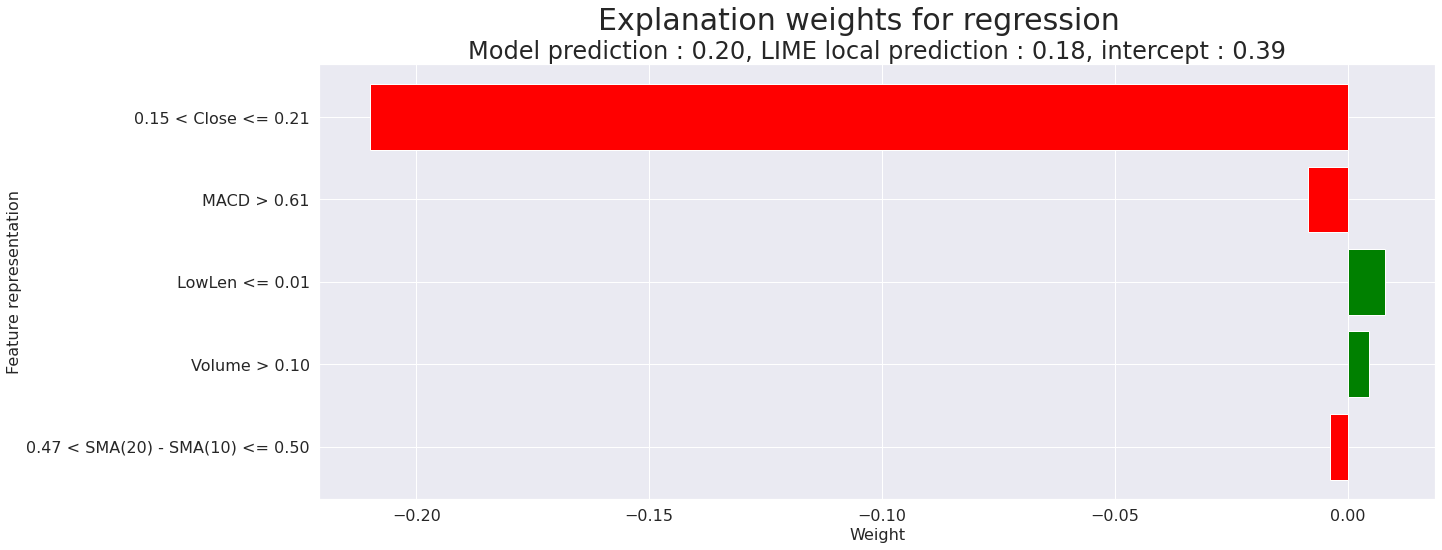

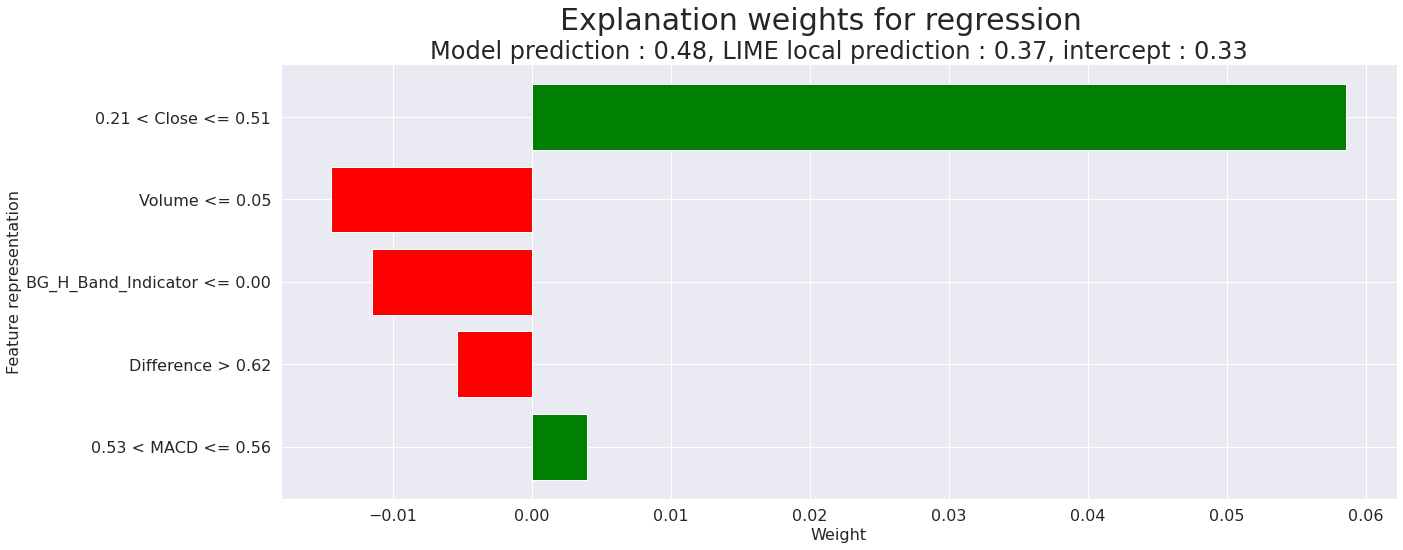

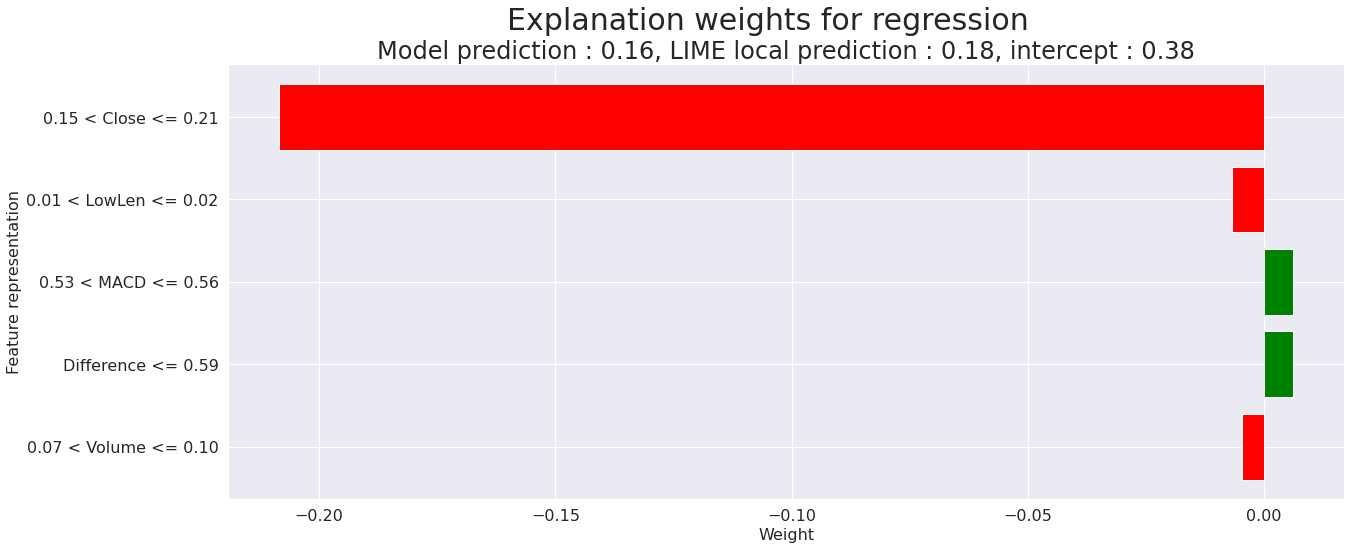

In [154]:
for exp in explanations:
    ax = plot_explanation(exp, mode='regression')

In [169]:
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds
from trainers.keras_regression_trainer import KerasRegressionTrainer
from models.keras_lstm_model import LSTMModel
import tensorflow as tf

quot='AAPL'
predict_n=5
seq_len=5
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}", 
                                           compute_features=True, 
                                           predict_n=predict_n, 
                                           thresh_diff=THRESH_DIFF, normalize=True)
config_dict = dict(
    quotation=quotation,
    predict_n = predict_n,
    features=days_predict_feature_set[predict_n],
    learning_rate = 0.01,
    batch_size = 32,
    sequence_length=5,
    n_epochs = 100,
    n_splits = 1,
    val_size = 0.2,
)
config_dict['quotation'] = quot


X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2,
                                                             y_column='NextPrice', sequences=True, seq_len=5,
                                                             features_list=days_predict_feature_set[predict_n])
n_classes = len(np.unique(y_train))

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(config_dict['batch_size'])
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(config_dict['batch_size'])

model = LSTMModel(config_dict, seq_len, len(days_predict_feature_set[predict_n]), output_dim=1,
                  learning_rate=config_dict['learning_rate'], loss='mse', metrics=['accuracy'])
trainer = KerasRegressionTrainer(model, use_wandb=False, project_label="Report")
trainer.train(train_set)

{}

In [175]:
explanations = explain_model(model.predict, X_train, y_train, 
                             data_columns=days_predict_feature_set[predict_n], 
                             class_names=['lower','higher'], n_exps=20, mode='regression', recurrent=True)

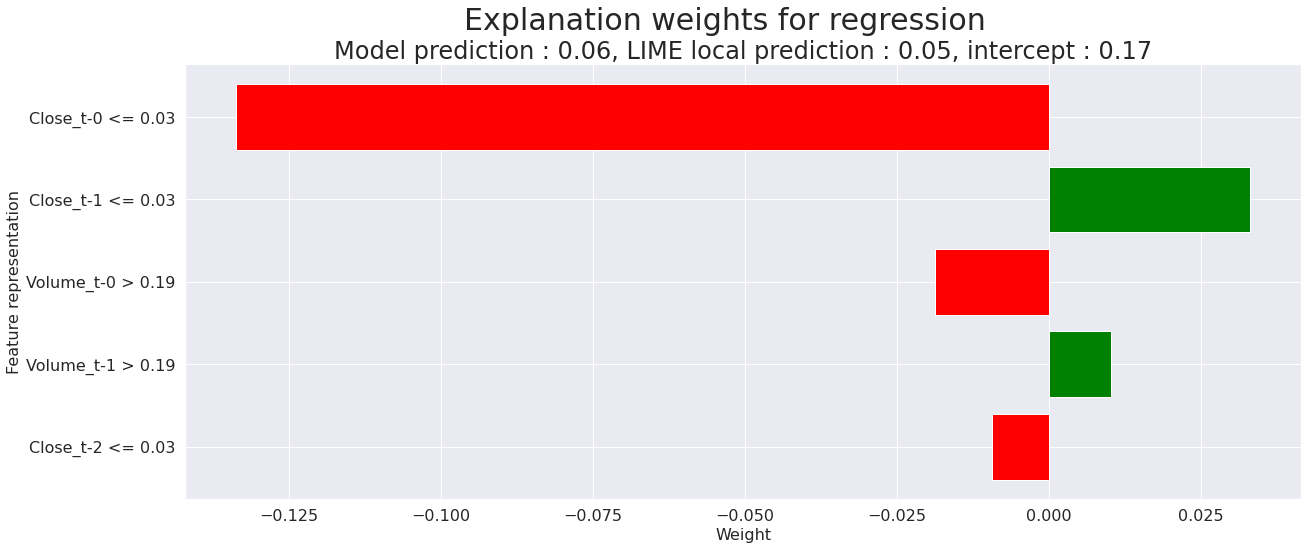

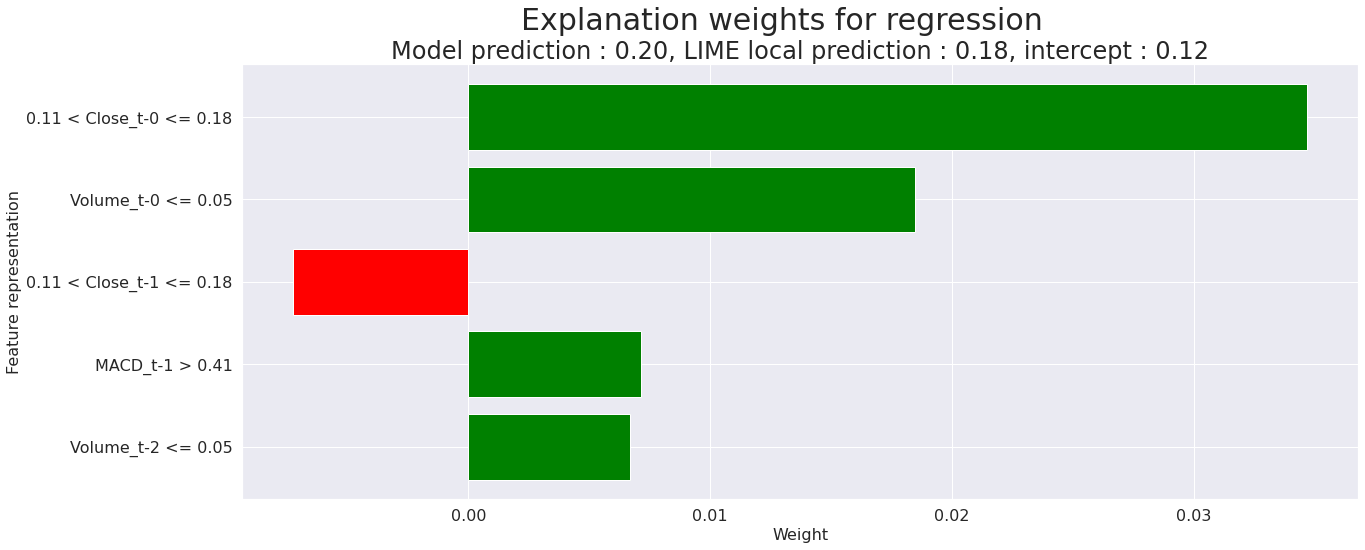

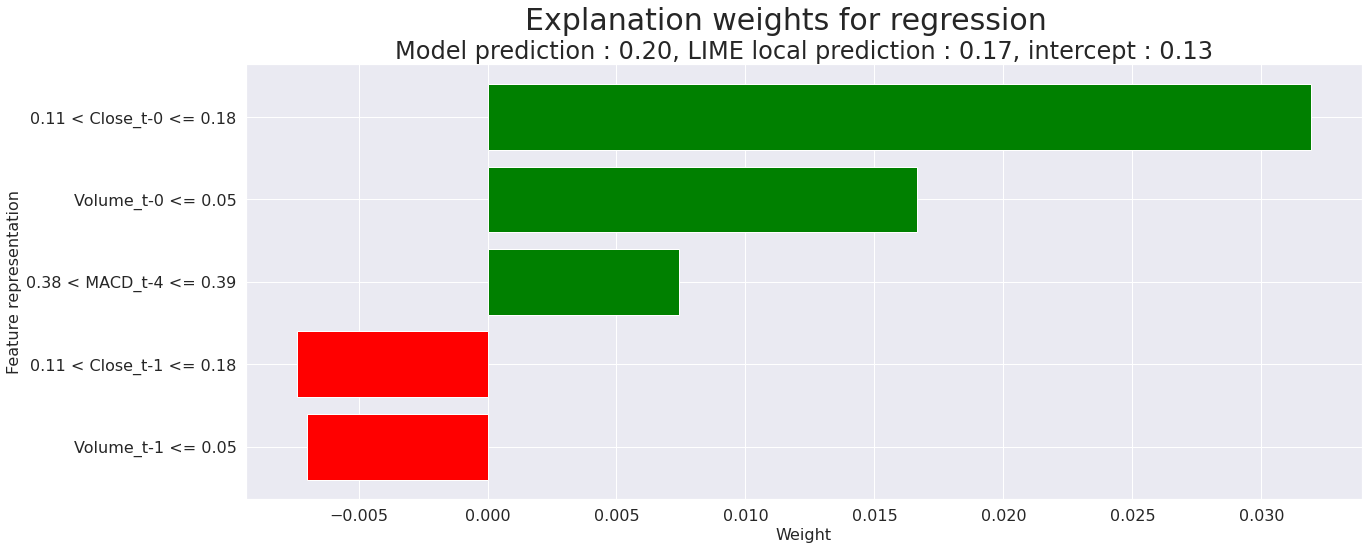

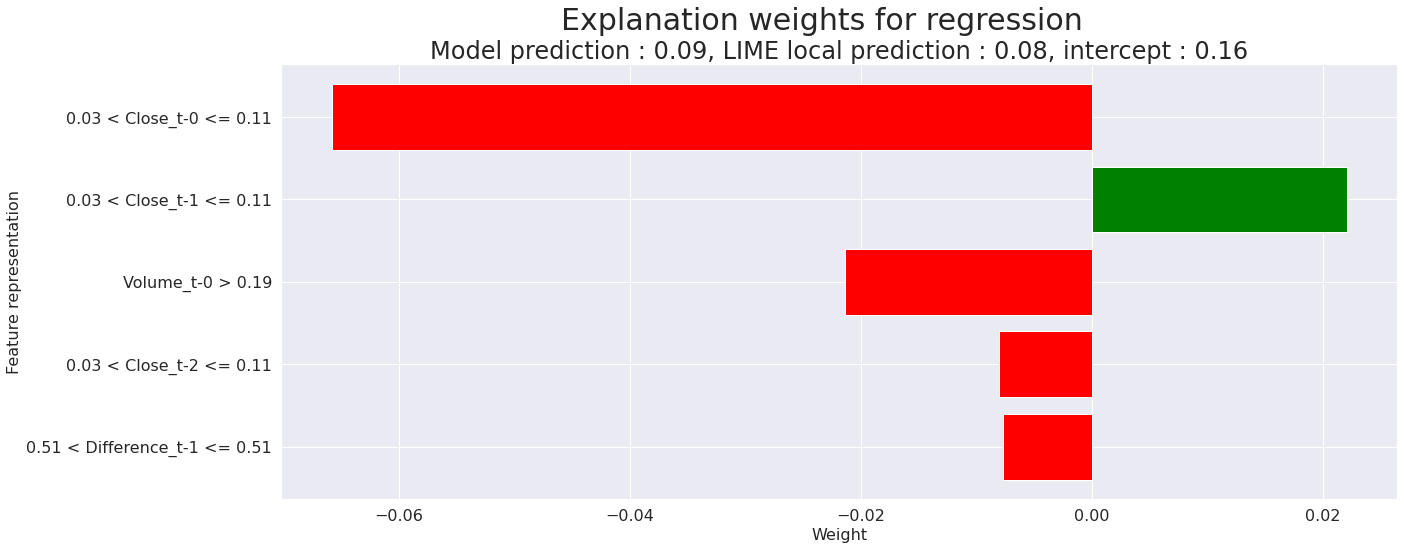

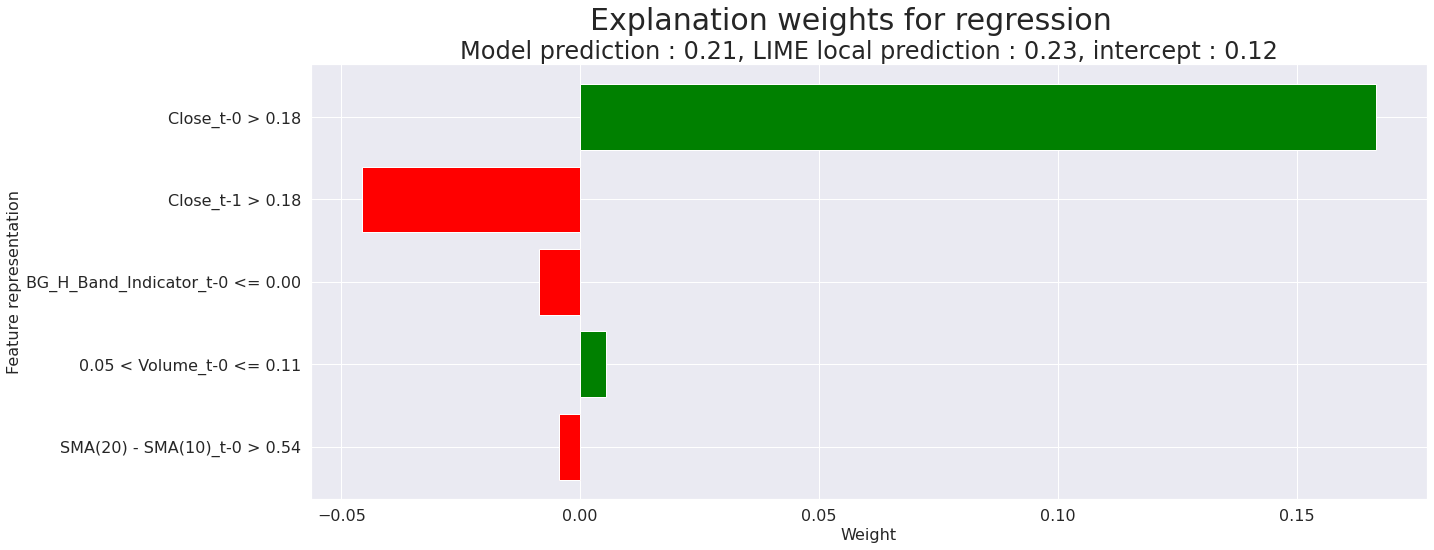

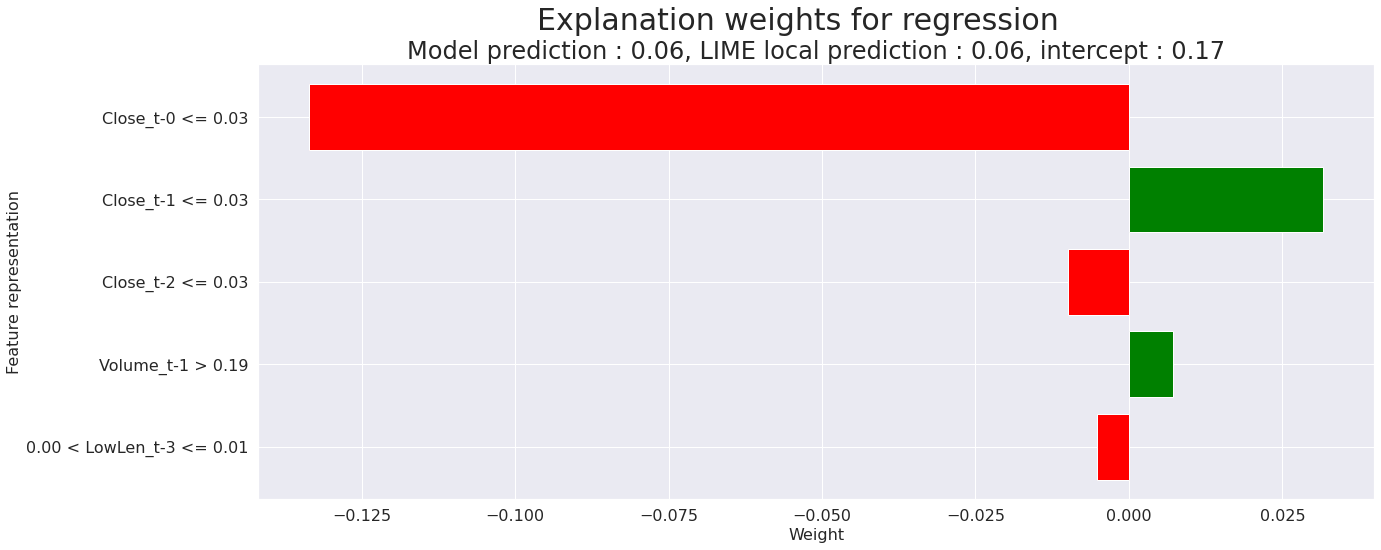

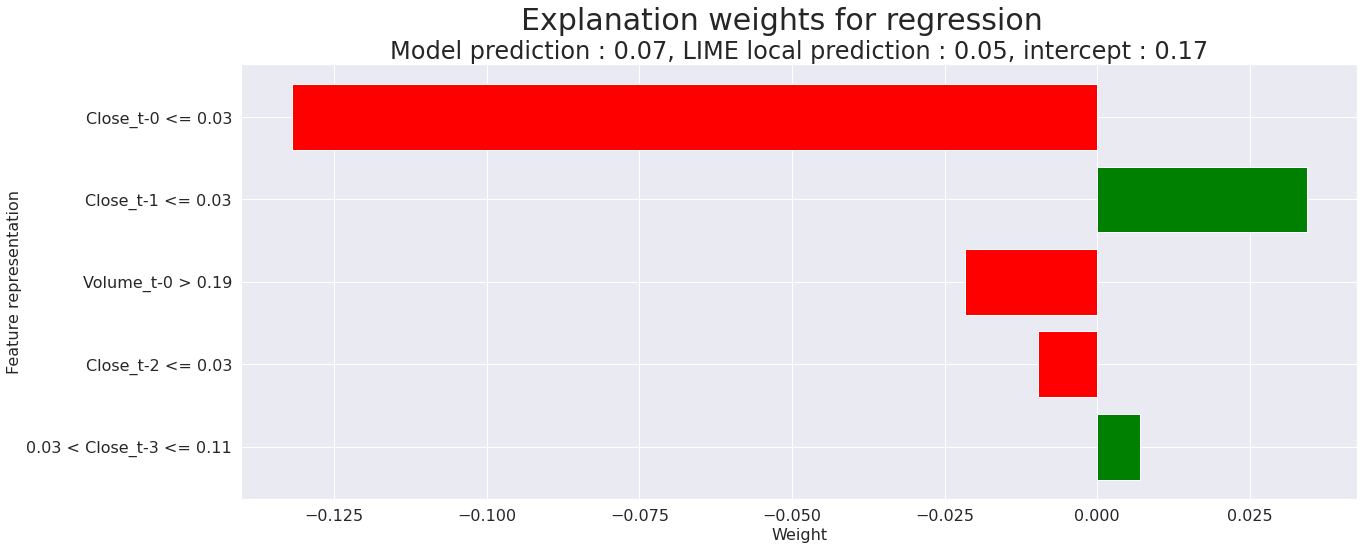

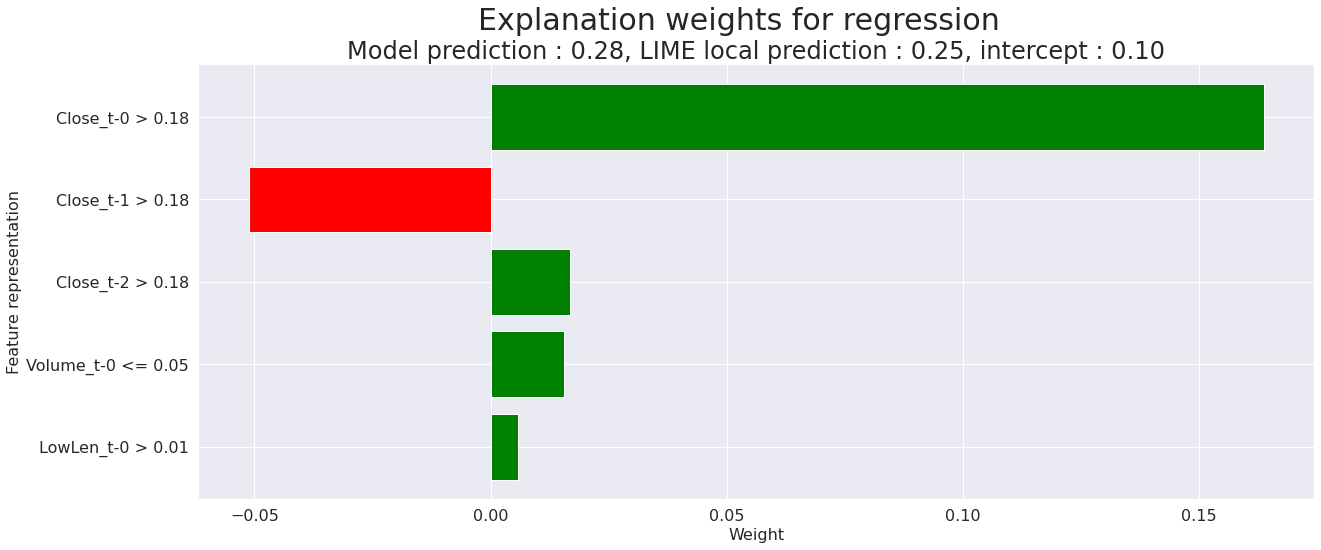

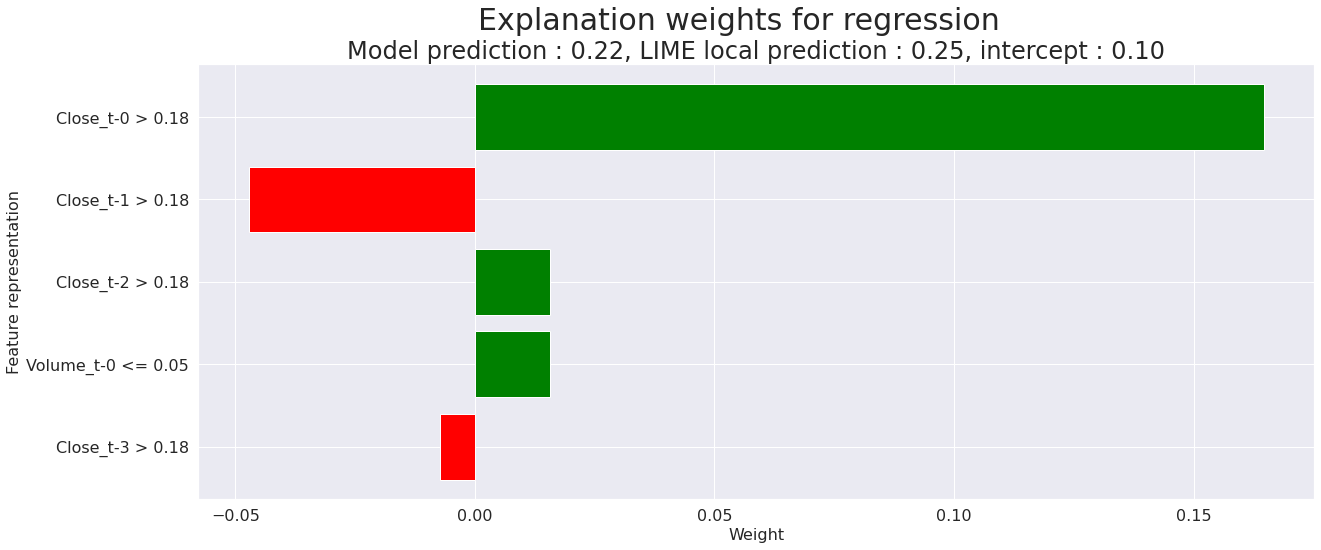

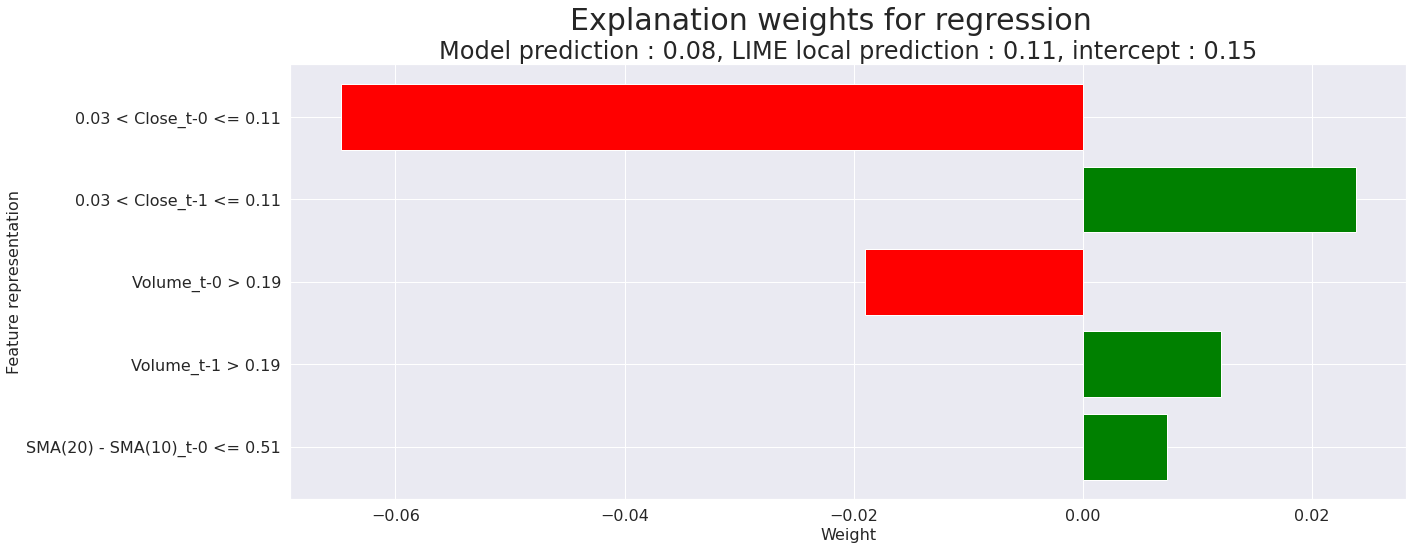

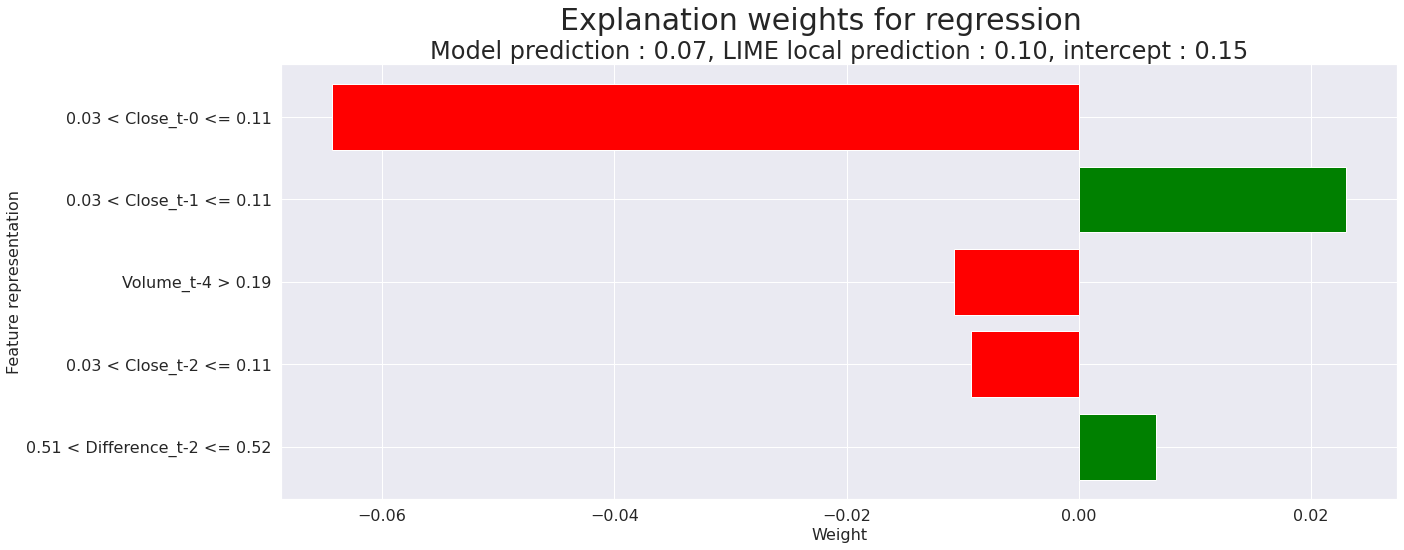

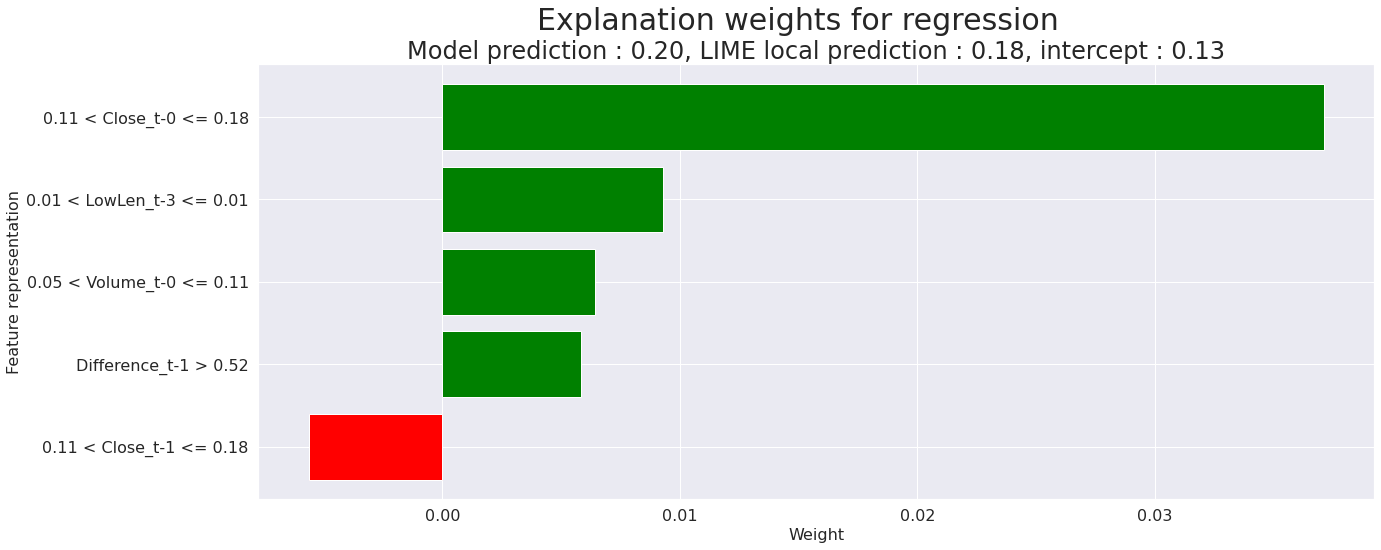

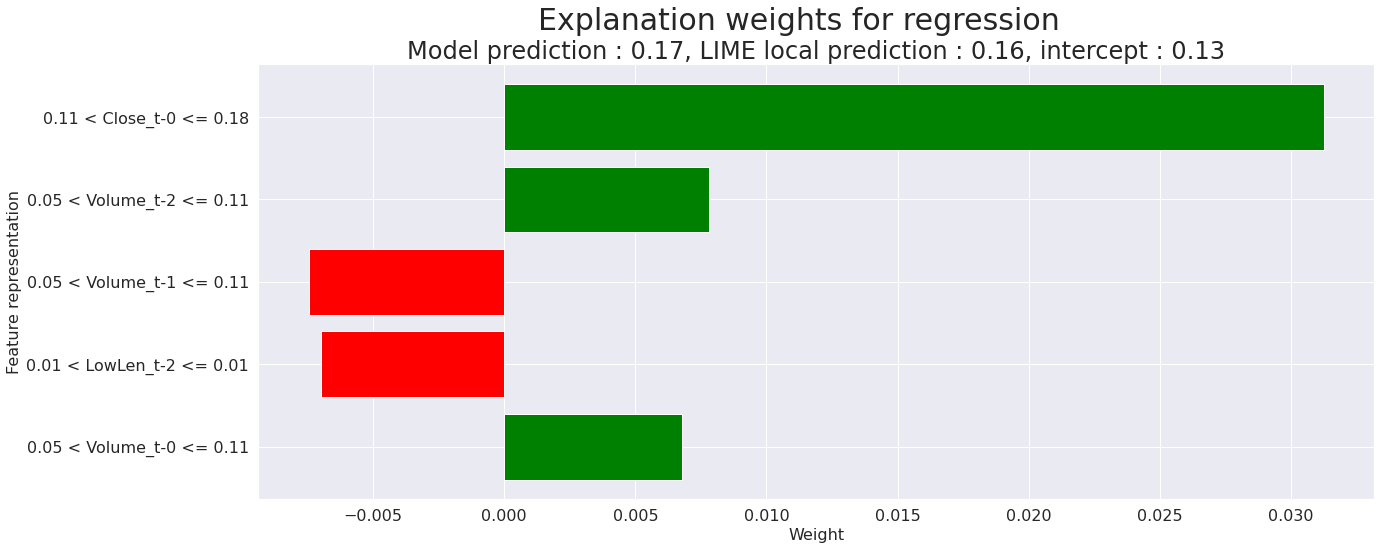

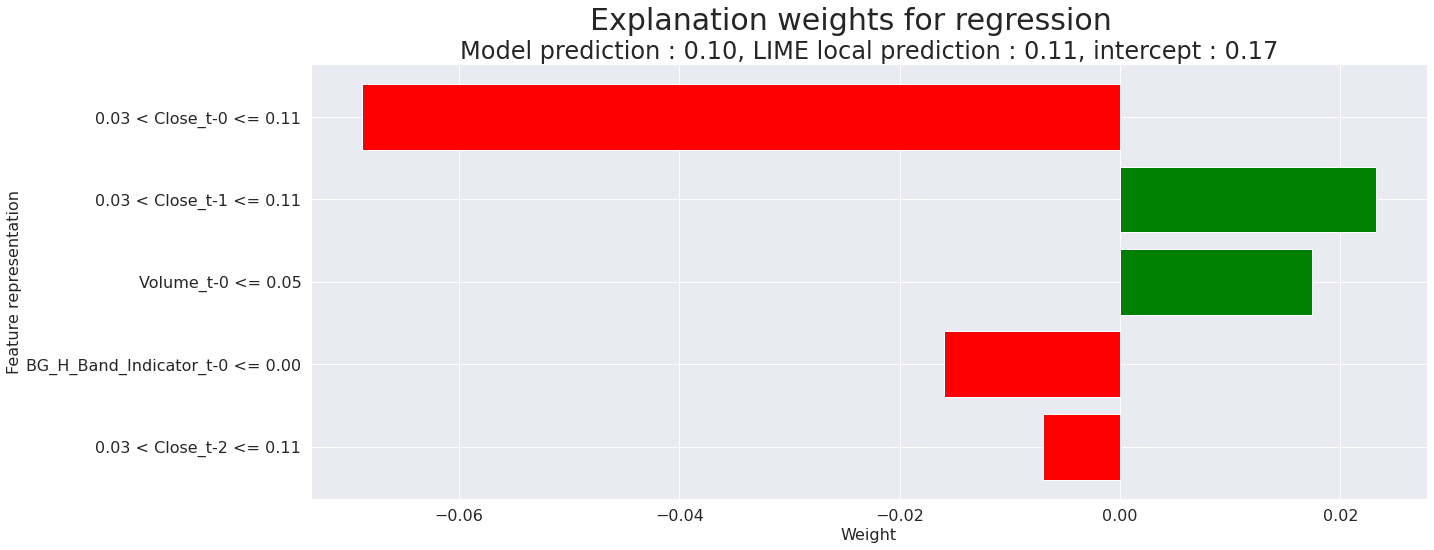

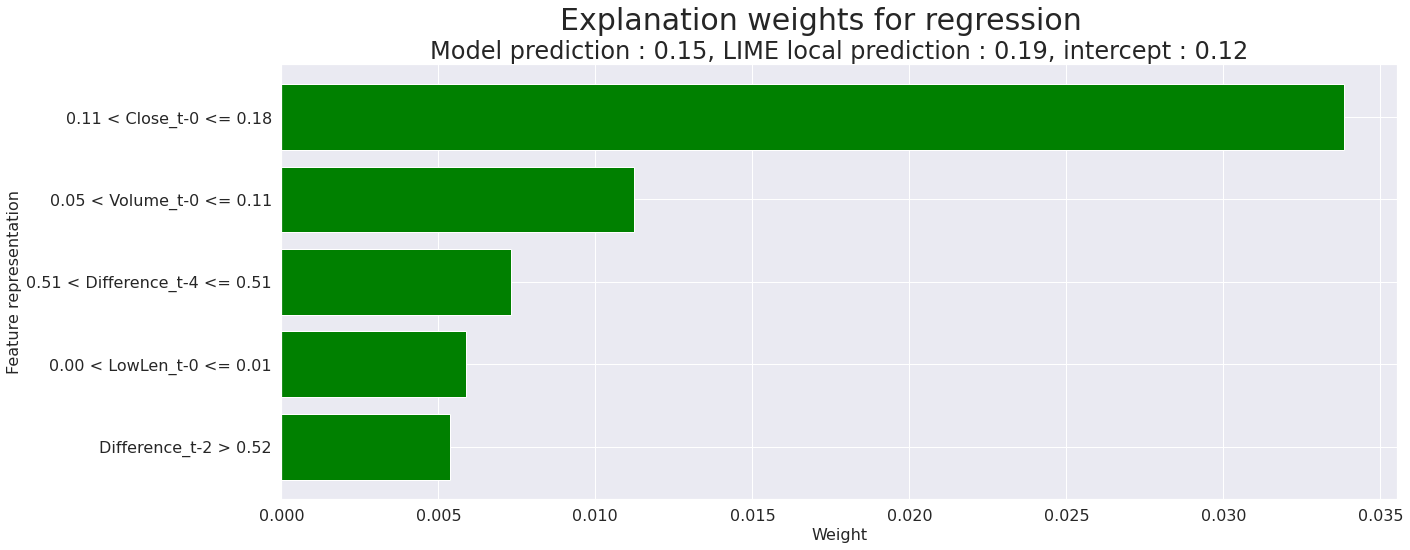

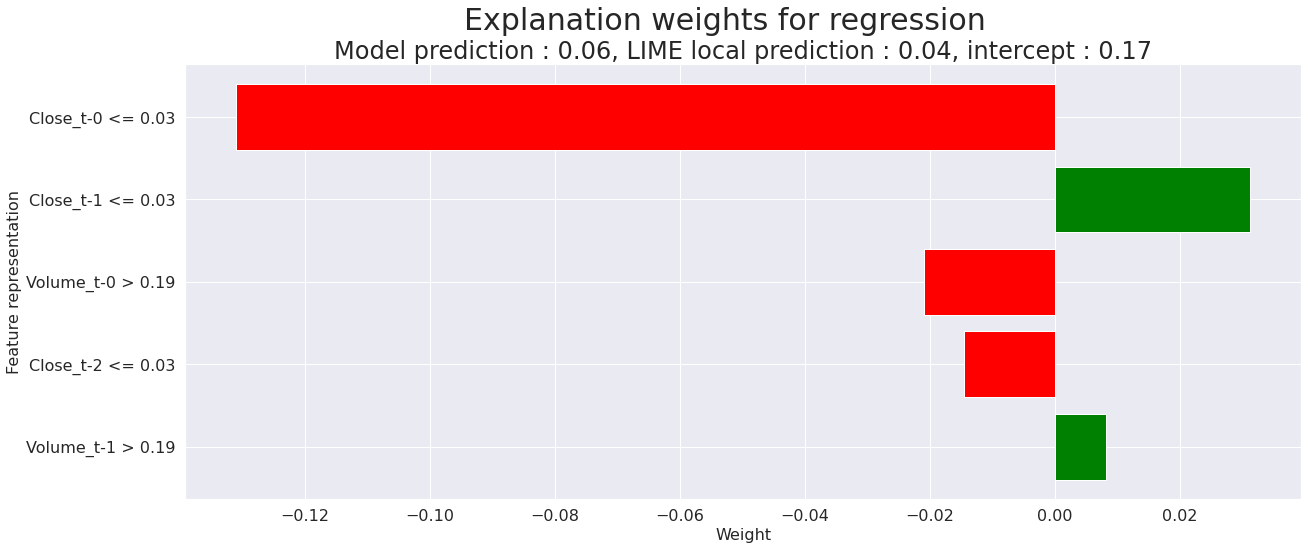

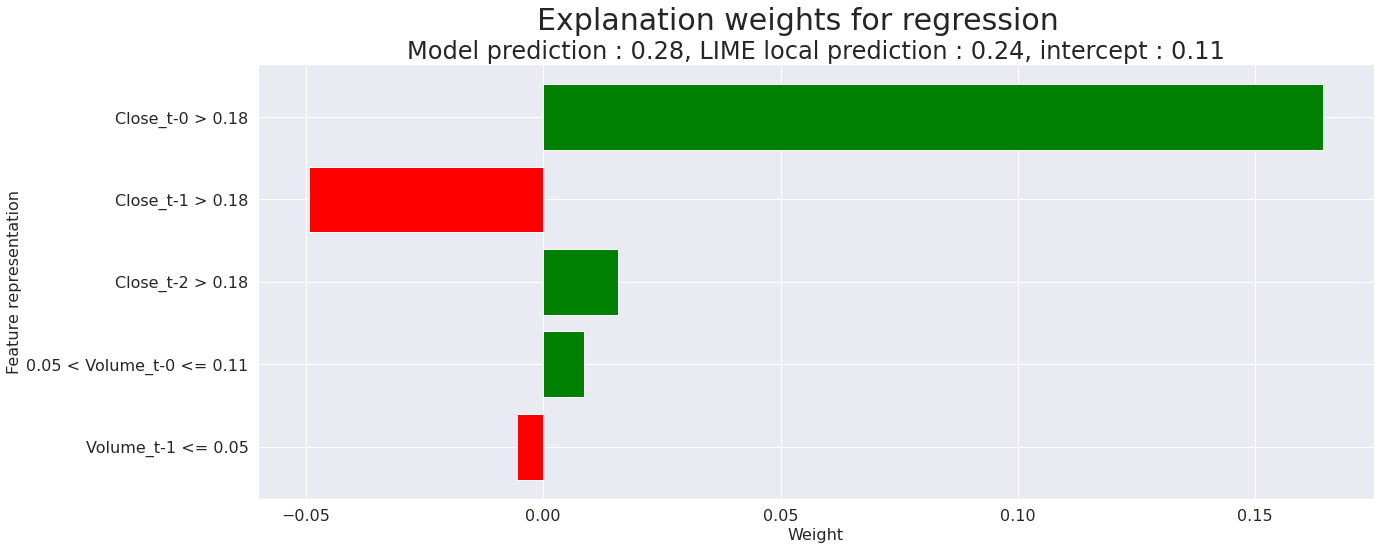

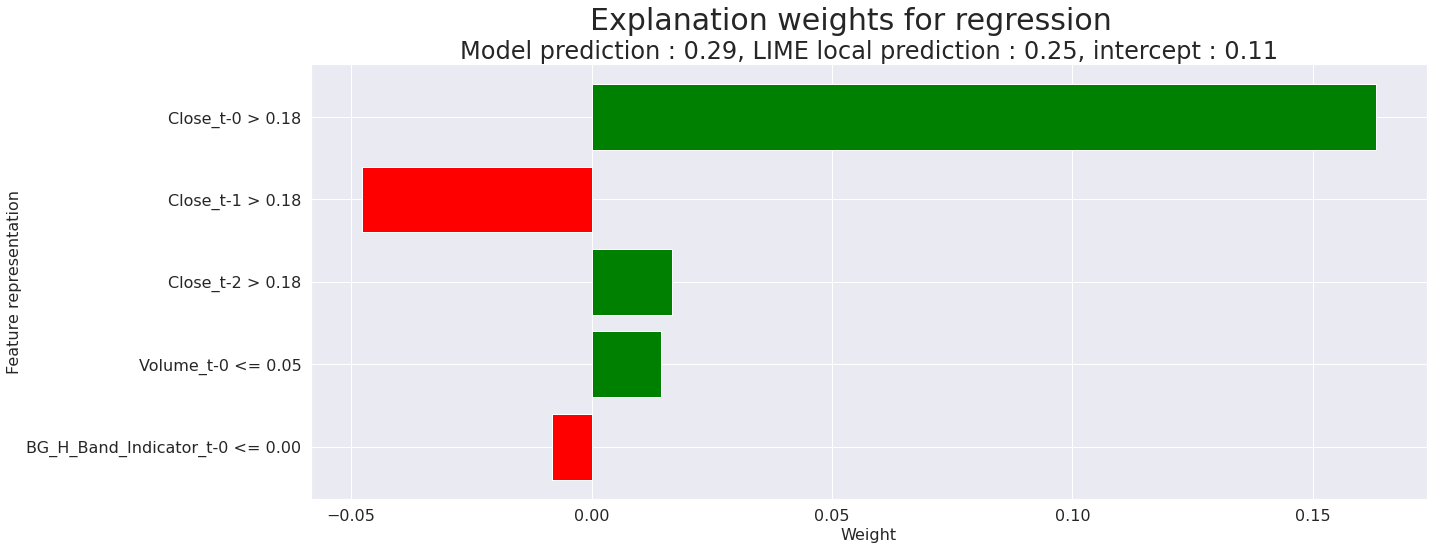

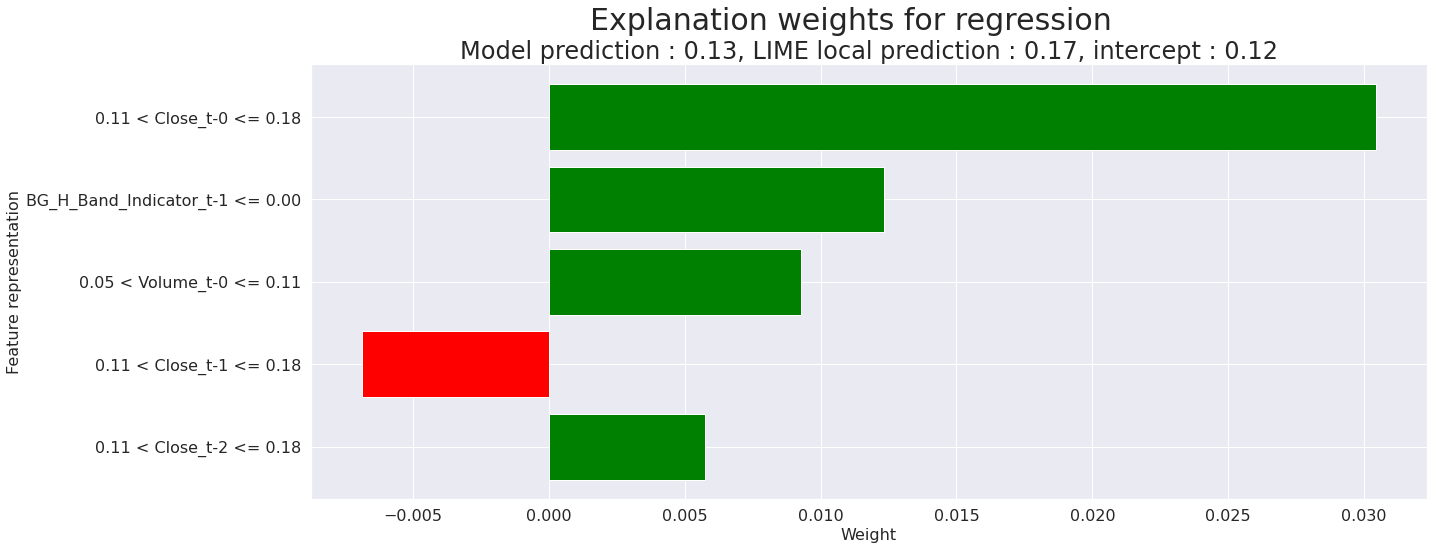

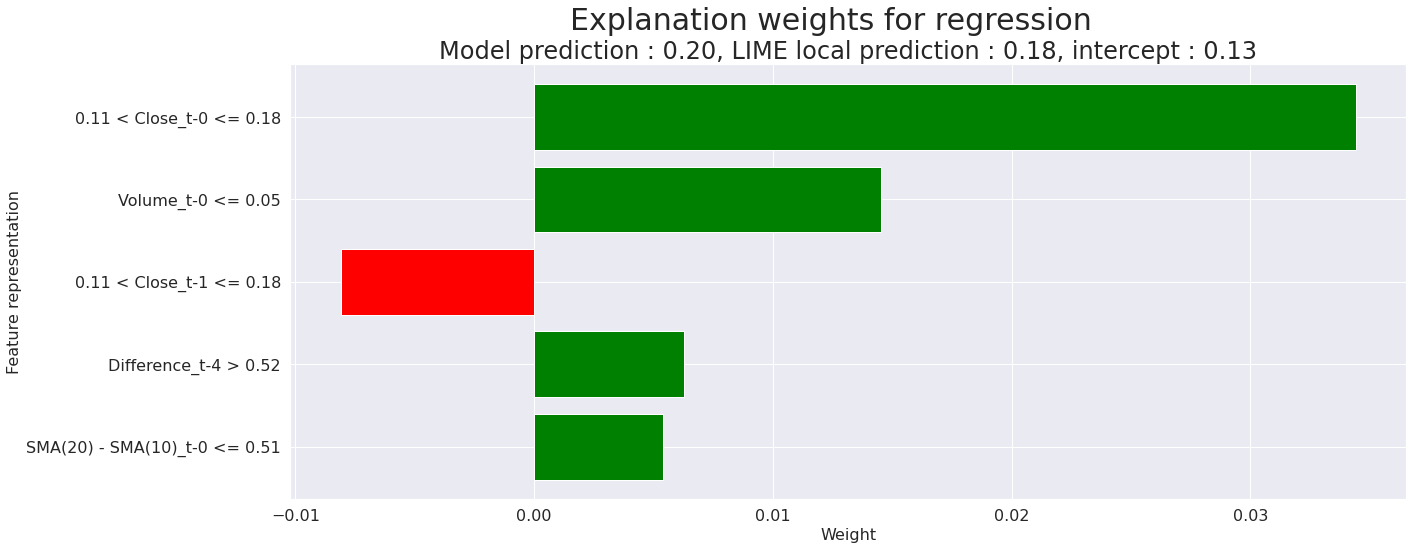

In [176]:
for exp in explanations:
    ax = plot_explanation(exp, mode='regression')

In [185]:
DATA_PATH = '../data/'
quotation = 'TSLA'
price_column = 'Close'

data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}.txt")

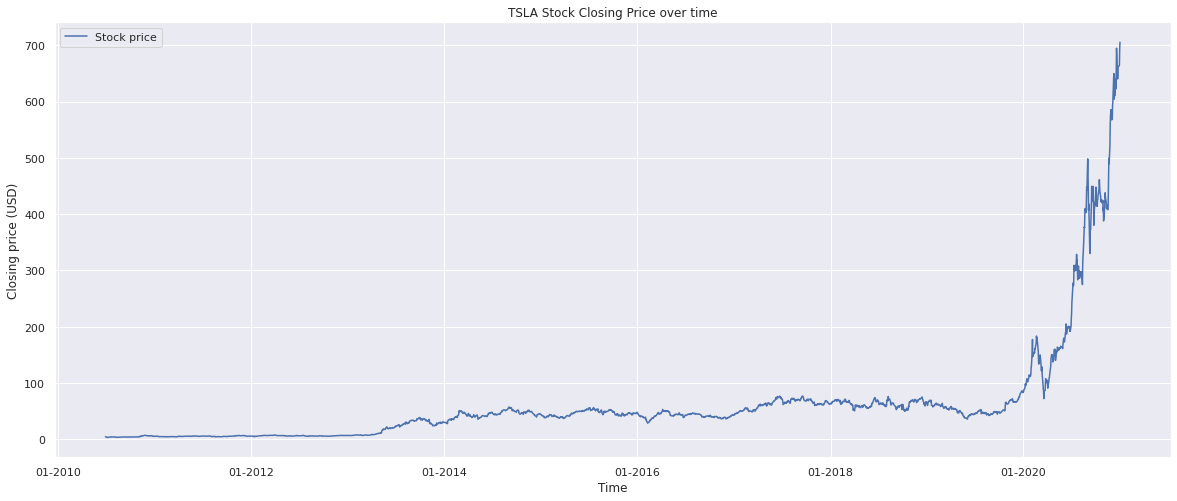

In [186]:
from helpers.plots_helper import plot_prices

ax = plot_prices(data_wrapper['Date'], data_wrapper[price_column], quotation_name=quotation)